# Data analysis and plotting

With this notebook, the intension is that is should be possible to reproduce the figures and the data analysis featured in the associated paper 

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy import integrate, signal


### Helper functions

In [2]:
# Path to figure folder
path_figure_folder = os.path.join(os.path.abspath(os.getcwd()), "Figures")

def save_figure(path_figure_folder, fileName, fig):
    """Utility function for saving files"""
    fig.savefig(os.path.join(path_figure_folder, (fileName + '.tif')), dpi=300, format='tif')
    fig.savefig(os.path.join(path_figure_folder, (fileName + '.png')), dpi=300, format='png')
    fig.savefig(os.path.join(path_figure_folder, (fileName + '.pdf')), dpi=300, format='pdf')

### UV-vis

In [3]:
# File paths
fileNameAbsData = "UV-vis_data.xlsx"
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "UV-vis")
path_data = os.path.join(path_data_folder, fileNameAbsData)

# Read in data
# The absorption data is collected in one excel file with one column for wavelength and the remaining columns for absorption 
absorption_data = pd.read_excel(path_data)

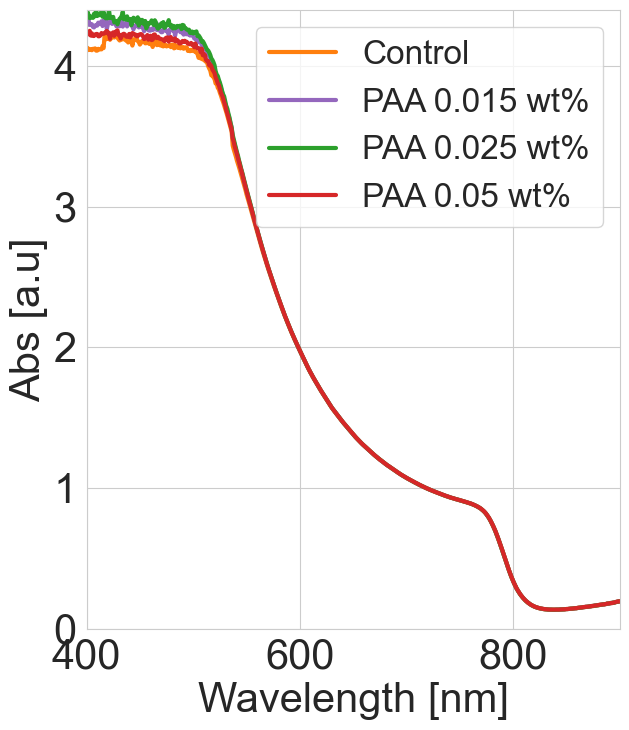

In [4]:
# Apply a default plot theme
sns.set_style("whitegrid")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(7, 8), tight_layout=True)

# Generate a line plot
sns.lineplot(data=absorption_data, x="Wavelength nm", y="Controll",
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="Control",
                ax=ax
                )

sns.lineplot(data=absorption_data, x="Wavelength nm", y="PAA 0.015",
                color=sns.color_palette("tab10")[4],
                lw=3,
                label="PAA 0.015 wt%",
                ax=ax
                )

sns.lineplot(data=absorption_data, x="Wavelength nm", y="PAA 0.025",
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PAA 0.025 wt%",
                ax=ax
                )

sns.lineplot(data=absorption_data, x="Wavelength nm", y="PAA 0.05",
                color=sns.color_palette("tab10")[3],
                lw=3,
                label="PAA 0.05 wt%",
                ax=ax
                )

ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Abs [a.u]")

ax.set_ylim([0, 4.4])
ax.set_xlim([400, 900])

ax.legend(fontsize=24)

# fileName = 'Absorption figure 3'
# save_figure(path_figure_folder, fileName, fig)

#### Tauc analysis

In [5]:
# Compute photon energies
absorption_data["hv"] = 1240 / absorption_data['Wavelength nm']

# (A*hv)^2 for absorption data
absorption_data["y0"] = (absorption_data['Controll'] * absorption_data['hv'])**2
absorption_data["y1"] = (absorption_data['PAA 0.015'] * absorption_data['hv'])**2
absorption_data["y2"] = (absorption_data["PAA 0.025"] * absorption_data['hv'])**2
absorption_data["y3"] = (absorption_data["PAA 0.05"] * absorption_data['hv'])**2

# Set an y-interval for where to do a linear regression (after first checking the data)
snit = [0.5, 1.5]

def extract_band_gap_tauc(data, x, y, snit):
    """Extract the optical band gap by a linear interpolation in the energy range given by snit"""
    
    # Determine the relevant energy range
    reduced_data = data[data[y] > snit[0]]
    reduced_data = reduced_data[reduced_data[y] < snit[1]]
    
    # Do a linear fit
    p = np.poly1d(np.polyfit(reduced_data[x], reduced_data[y], 1))
    
    # extract the band gap as the intercept with the fitted line and the x-axis
    Eg = -p[0]/p[1] 
    
    # return the band gap and the fit
    return Eg, p    

# Extract the band gaps
Eg = []
p = []
ys = ["y0", "y1", "y2", "y3"]
for y in ys:
    (a, b) = extract_band_gap_tauc(data=absorption_data, x="hv", y=y, snit=snit)
    Eg.append(a)
    p.append(b)

Text(0.5, 0, 'Energy [eV]')

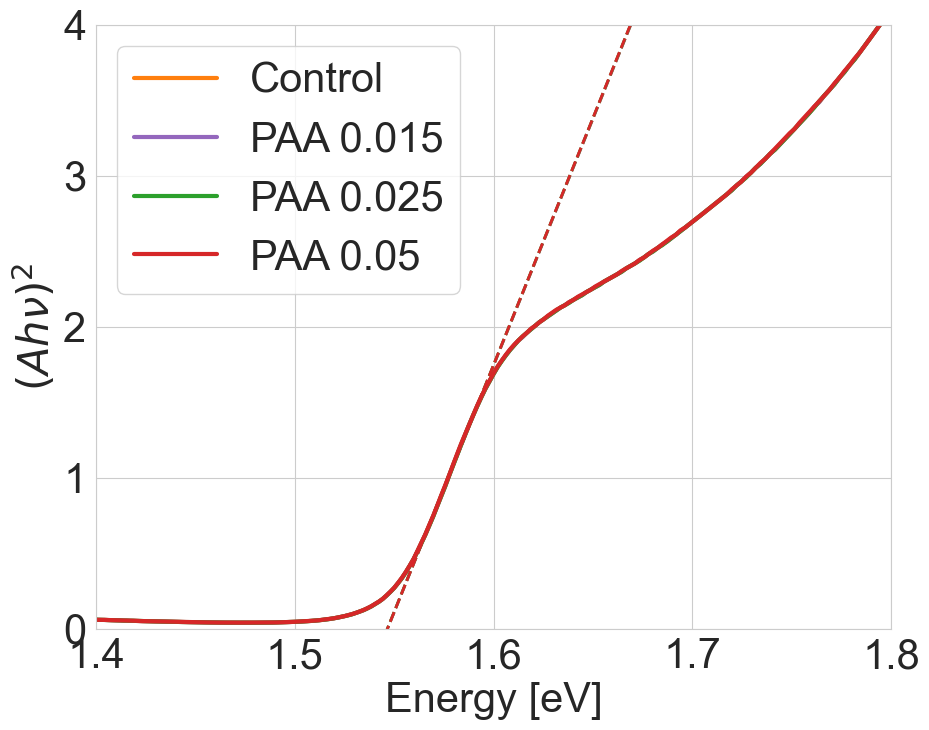

In [6]:
# Plot the band gap data
# Apply a default plot theme
sns.set_style("whitegrid")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

fit_range = np.linspace(0, 4, 100)

# Generate a scatter plot
line_0 = sns.lineplot(data=absorption_data, x="hv", y="y1",
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="Control",
                ax=ax
                )

line_0_eg = sns.lineplot(x=fit_range, y=p[0](fit_range),
                color=sns.color_palette("tab10")[1],
                lw=2,
                linestyle="--",
                ax=ax
                )

line_1 = sns.lineplot(data=absorption_data, x="hv", y="y1",
                color=sns.color_palette("tab10")[4],
                lw=3,
                label="PAA 0.015",
                ax=ax
                )

line_1_eg = sns.lineplot(x=fit_range, y=p[0](fit_range),
                color=sns.color_palette("tab10")[4],
                lw=2,
                linestyle="--",
                ax=ax
                )

line_2 = sns.lineplot(data=absorption_data, x="hv", y="y2",
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PAA 0.025",
                ax=ax
                )

line_2_eg = sns.lineplot(x=fit_range, y=p[1](fit_range),
                color=sns.color_palette("tab10")[2],
                lw=2,
                linestyle="--",
                ax=ax
                )

line_3 = sns.lineplot(data=absorption_data, x="hv", y="y3",
                color=sns.color_palette("tab10")[3],
                lw=3,
                label="PAA 0.05",
                ax=ax
                )

line_3_eg = sns.lineplot(x=fit_range, y=p[2](fit_range),
                color=sns.color_palette("tab10")[3],
                lw=2,
                linestyle="--",
                ax=ax
                )

ax.set_ylim([0, 4])
ax.set_xlim([1.4, 1.8])

ax.set_ylabel("$(Ah\\nu)^2$")
ax.set_xlabel("Energy [eV]")

# fileName = 'Absorption tauc 2'
# save_figure(path_figure_folder, fileName, fig)

In [7]:
# The extracted band gap values
Eg

[1.5466411980709676, 1.546562428552701, 1.5466052091673252, 1.546465792932447]

### XRD

#### Read in data

In [8]:
# File paths
files = ["20231019-pin-c.csv", "20231019-pin-0.015%p.csv", "20231019-pin-0.025%p.csv", "20231019-pin-0.05%p.csv"]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "XRD")
path_data = [os.path.join(path_data_folder, file) for file in files]

# Read in data
XRD = [pd.read_csv(path, header=21, sep=",", encoding='ISO-8859-1') for path in path_data]

# Apply some gliding averaging
for spectra in XRD:
    spectra["Smooth"] = spectra[" Intensity"].rolling(3).mean()

# Remove data for angels less than 7°
for spectra in XRD:
    index = spectra[spectra["Angle"] < 7].index
    spectra.drop(index, inplace=True)

#### Individual figures

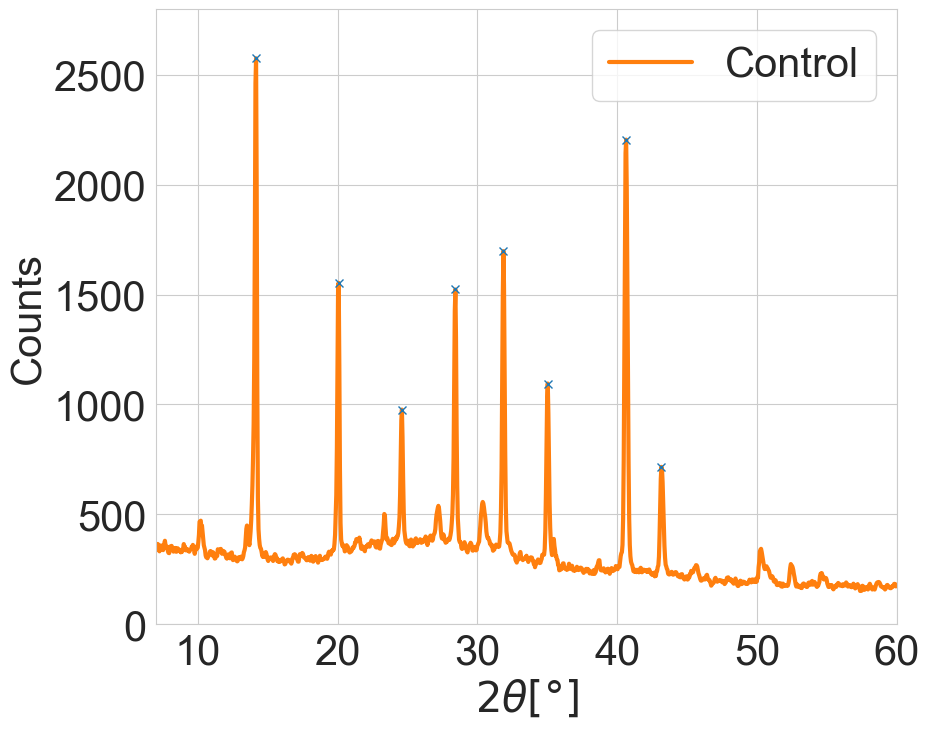

In [9]:
# Control sample
# Determine peak positions
signal = XRD[0]["Smooth"]
peaks_1, peak_heights_1 = find_peaks(signal, height=600)

# Apply a default plot theme
sns.set_style("whitegrid")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot
sns.lineplot(data=XRD[0], x="Angle", y="Smooth",
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="Control",
                ax=ax
                )

ax.plot(XRD[0]["Angle"].iloc[list(peaks_1)], peak_heights_1["peak_heights"], "x", lw=9)
# ax.plot(np.zeros_like(signal), "--", color="gray")

ax.set_xlabel("$2\\theta [°]$")
ax.set_ylabel("Counts")

ax.set_xlim([7, 60])
ax.set_ylim([0, 2800])
ax.set_xticks([10, 20, 30, 40, 50, 60])

# fileName = 'XRD fig 1 control v1'
# save_figure(path_figure_folder, fileName, fig)

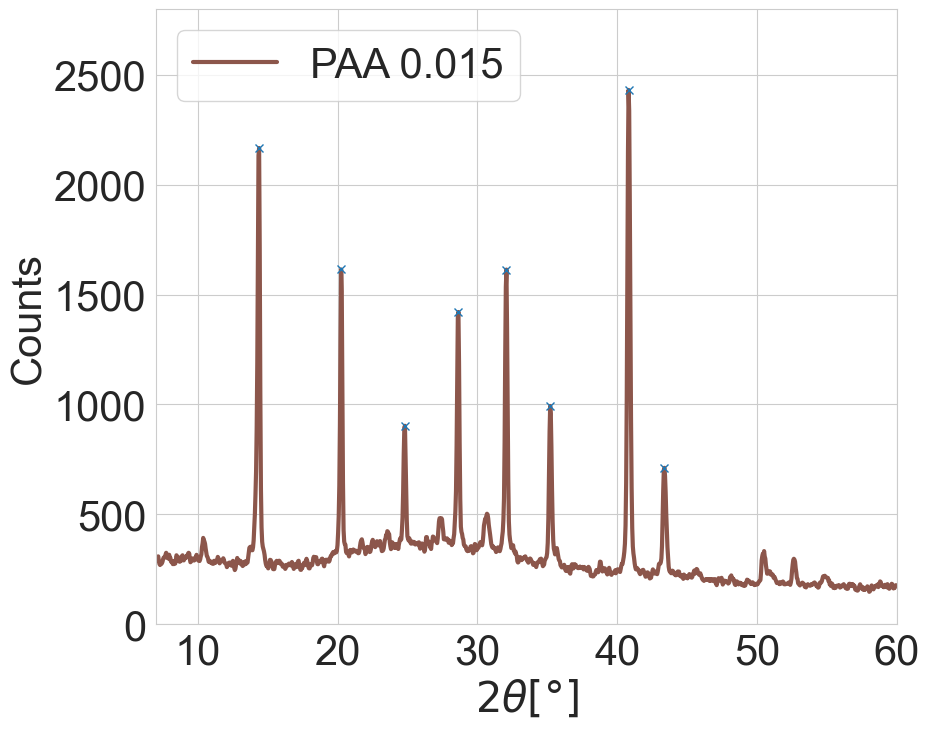

In [12]:
# PAA 0.015
# Determine peak positions
signal = XRD[1]["Smooth"]
peaks_2, peak_heights_2 = find_peaks(signal, height=600)

# Apply a default plot theme
sns.set_style("whitegrid")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot
sns.lineplot(data=XRD[1], x="Angle", y="Smooth",
                color=sns.color_palette("tab10")[5],
                lw=3,
                label="PAA 0.015",
                ax=ax
                )

ax.plot(XRD[1]["Angle"].iloc[list(peaks_2)], peak_heights_2["peak_heights"], "x", lw=9)

ax.set_xlabel("$2\\theta [°]$")
ax.set_ylabel("Counts")

ax.set_xlim([7, 60])
ax.set_ylim([0, 2800])
ax.set_xticks([10, 20, 30, 40, 50, 60])

# fileName = 'XRD fig 2 PAA 0.015 v1'
# save_figure(path_figure_folder, fileName, fig)

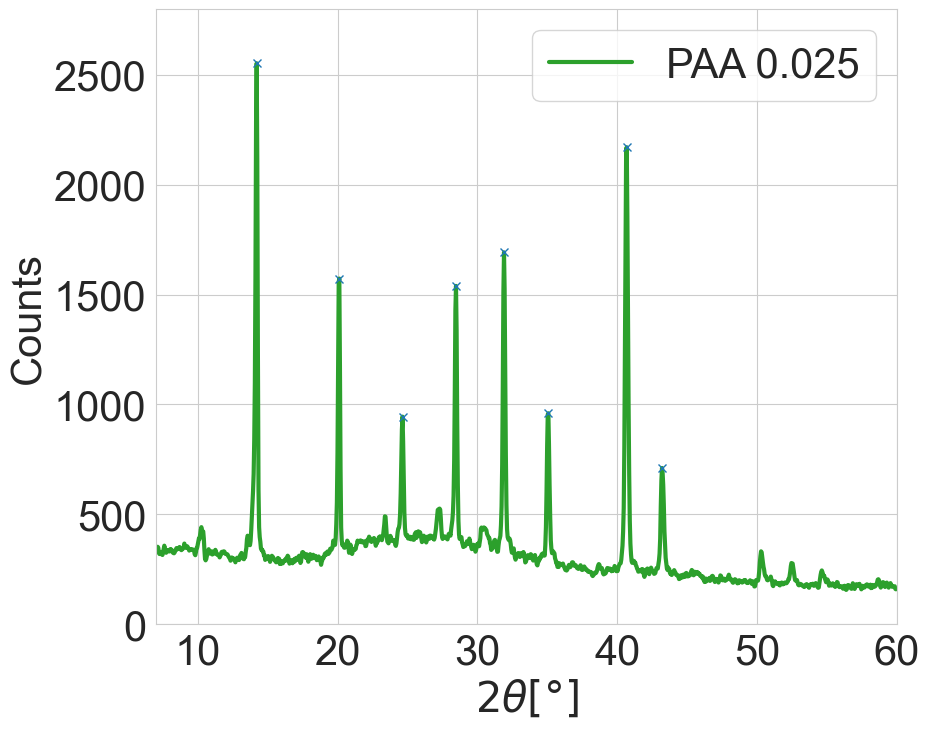

In [16]:
# PAA 0.025
# Determine peak positions
signal = XRD[2]["Smooth"]
peaks_3, peak_heights_3 = find_peaks(signal, height=600)

# Apply a default plot theme
sns.set_style("whitegrid")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot
sns.lineplot(data=XRD[2], x="Angle", y="Smooth",
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PAA 0.025",
                ax=ax
                )

ax.plot(XRD[2]["Angle"].iloc[list(peaks_3)], peak_heights_3["peak_heights"], "x", lw=9)

ax.set_xlabel("$2\\theta [°]$")
ax.set_ylabel("Counts")

ax.set_xlim([7, 60])
ax.set_ylim([0, 2800])
ax.set_xticks([10, 20, 30, 40, 50, 60])

# fileName = 'XRD fig 3 PAA 0.025 v1'
# save_figure(path_figure_folder, fileName, fig)

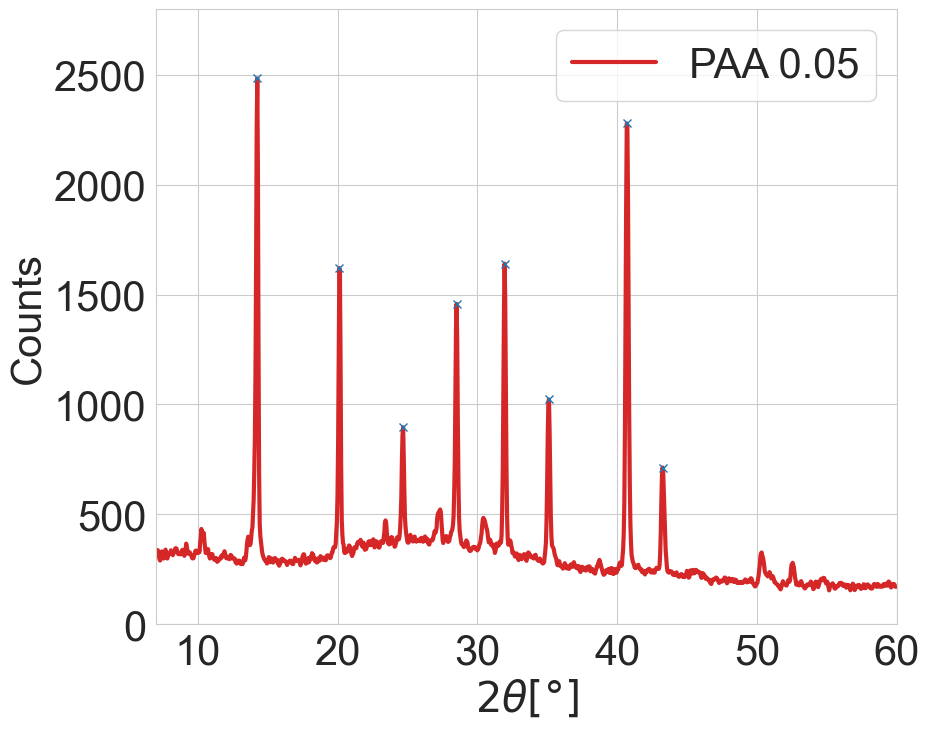

In [14]:
# PAA 0.05
# Determine peak positions
signal = XRD[3]["Smooth"]
peaks_4, peak_heights_4 = find_peaks(signal, height=600)

# Apply a default plot theme
sns.set_style("whitegrid")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot
sns.lineplot(data=XRD[3], x="Angle", y="Smooth",
                color=sns.color_palette("tab10")[3],
                lw=3,
                label="PAA 0.05",
                ax=ax
                )

ax.plot(XRD[3]["Angle"].iloc[list(peaks_4)], peak_heights_4["peak_heights"], "x", lw=9)

ax.set_xlabel("$2\\theta [°]$")
ax.set_ylabel("Counts")

ax.set_xlim([7, 60])
ax.set_ylim([0, 2800])
ax.set_xticks([10, 20, 30, 40, 50, 60])

# fileName = 'XRD fig 4 PAA 0.05 v1'
# save_figure(path_figure_folder, fileName, fig)

#### Analyse peak positions

In [17]:
# Extract peak positions and heights into a datafram
# the miller indexes correspond to a cubic structure 
XRD_peaks = pd.DataFrame(data={
    'h': [0, 0, 1, 0, 0, 1, 0, 0],
    'k': [0, 1, 1, 0, 1, 1, 2, 0,],
    'l': [1, 1, 1, 2, 2, 2, 2, 3],
    'control_theta': XRD[0]["Angle"].iloc[list(peaks_1)].values,
    'control_height': peak_heights_1["peak_heights"],
    'PAA_015_theta': XRD[1]["Angle"].iloc[list(peaks_2)].values,
    'PAA_015_height': peak_heights_2["peak_heights"],
    'PAA_025_theta': XRD[2]["Angle"].iloc[list(peaks_3)].values,
    'PAA_025_height': peak_heights_3["peak_heights"],
    'PAA_05_theta': XRD[3]["Angle"].iloc[list(peaks_4)].values,
    'PAA_05_height': peak_heights_4["peak_heights"],
})

# Compute d values
lam = 1.54 # Cu K_alpha 
XRD_peaks["control_d"] = lam/(2*np.sin(np.deg2rad(XRD_peaks["control_theta"])/2))
XRD_peaks["PAA_015_d"] = lam/(2*np.sin(np.deg2rad(XRD_peaks["PAA_015_theta"])/2))
XRD_peaks["PAA_025_d"] = lam/(2*np.sin(np.deg2rad(XRD_peaks["PAA_025_theta"])/2))
XRD_peaks["PAA_05_d"] = lam/(2*np.sin(np.deg2rad(XRD_peaks["PAA_05_theta"])/2))

# Estimate cell parameter. Assumption of cubic structure. Per reflection 
XRD_peaks["control_a"] = np.sqrt(XRD_peaks["control_d"]**2 * (XRD_peaks["h"]**2 + XRD_peaks["k"]**2 + XRD_peaks["l"]**2))
XRD_peaks["PAA_015_a"] = np.sqrt(XRD_peaks["PAA_015_d"]**2 * (XRD_peaks["h"]**2 + XRD_peaks["k"]**2 + XRD_peaks["l"]**2))
XRD_peaks["PAA_025_a"] = np.sqrt(XRD_peaks["PAA_025_d"]**2 * (XRD_peaks["h"]**2 + XRD_peaks["k"]**2 + XRD_peaks["l"]**2))
XRD_peaks["PAA_05_a"] = np.sqrt(XRD_peaks["PAA_05_d"]**2 * (XRD_peaks["h"]**2 + XRD_peaks["k"]**2 + XRD_peaks["l"]**2))

XRD_peaks

h  k  l  control_theta  control_height  PAA_015_theta  PAA_015_height  \
0  0  0  1      14.164967     2575.666667      14.382296     2167.333333   
1  0  1  1      20.076311     1553.666667      20.250174     1614.666667   
2  1  1  1      24.596750      976.666667      24.814079      903.000000   
3  0  0  2      28.421737     1523.333333      28.639066     1421.000000   
4  0  1  2      31.855532     1698.000000      32.072861     1614.000000   
5  1  1  2      35.028532     1095.333333      35.202395      993.333333   
6  0  2  2      40.635615     2205.333333      40.809478     2431.666667   
7  0  0  3      43.156629      716.000000      43.373958      711.666667   

   PAA_025_theta  PAA_025_height  PAA_05_theta  PAA_05_height  control_d  \
0      14.208433     2553.000000     14.251899    2484.000000   6.245027   
1      20.119777     1573.000000     20.119777    1620.666667   4.417570   
2      24.640216      944.666667     24.683681     896.333333   3.614978   
3      28.465202     1539.666667     28.508668    1458.000000   3.136568   
4      31.898998     1692.333333     31.942463    1640.666667   2.805864   
5      35.071998      960.000000     35.115464    1022.666667   2.558622   
6      40.679081     2170.666667     40.679081    2279.000000   2.217569   
7      43.200095      711.000000     43.243561     713.000000   2.093685   

   PAA_015_d  PAA_025_d  PAA_05_d  control_a  PAA_015_a  PAA_025_a  PAA_05_a  
0   6.151145   6.226020  6.207130   6.245027   6.151145   6.226020  6.207130  
1   4.380033   4.408125  4.408125   6.247388   6.194302   6.234030  6.234030  
2   3.583807   3.608700  3.602443   6.261326   6.207336   6.250451  6.239615  
3   3.113258   3.131877  3.127201   6.273135   6.226515   6.263754  6.254401  
4   2.787345   2.802140  2.798426   6.274103   6.232694   6.265776  6.257471  
5   2.546382   2.555550  2.552487   6.267318   6.237337   6.259794  6.252290  
6   2.208521   2.215299  2.215299   6.272231   6.246641   6.265813  6.265813  
7   2.083696   2.091679  2.089677   6.281055   6.251089   6.275037  6.269031

In [18]:
# Extract cell parameters by linear least square fitting. Assuming a cubic phase
d_labels = ["control_d", "PAA_015_d", "PAA_025_d", "PAA_05_d"]
a = []
for d in d_labels:
    x = XRD_peaks["h"]**2 + XRD_peaks["k"]**2 + XRD_peaks["l"]**2
    x = x.values
    x = x[:,np.newaxis]
    y = 1/(XRD_peaks[d].values)**2
    
    k = np.linalg.lstsq(x, y, rcond=None)
    a.append(np.sqrt(1/k[0][0]))

# cell parameters
a

[6.273806437726938, 6.24107207099885, 6.266607849775913, 6.261390190595515]

#### Combined XRD plot

In [19]:
# Normalise the data
offsets = [0, 1, 2, 3]
for i, spectra in enumerate(XRD):
    # Shift down
    spectra["Smooth_norm"] = spectra["Smooth"] - spectra["Smooth"].min()
    # Normalise
    spectra["Smooth_norm"] = spectra["Smooth_norm"] / spectra["Smooth_norm"].max()
    # Add an offset
    spectra["Smooth_norm"] = spectra["Smooth_norm"] + offsets[i]

# Determine average peak position
peak_positions = (XRD_peaks["control_theta"] + XRD_peaks["PAA_015_theta"] + XRD_peaks["PAA_025_theta"] + XRD_peaks["PAA_05_theta"])/4
peak_positions = peak_positions.values

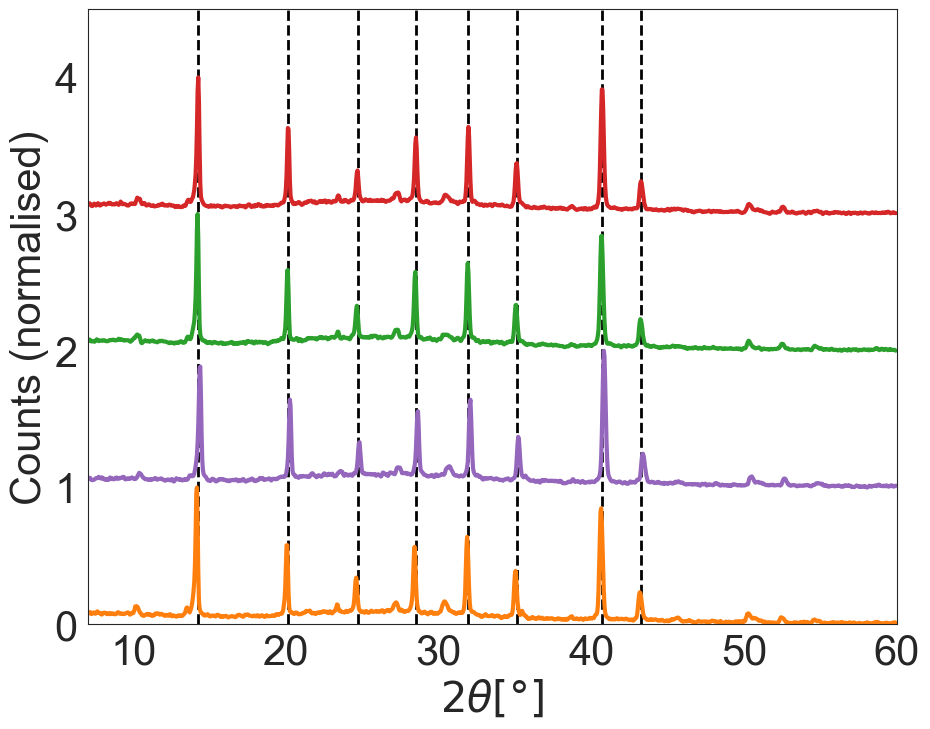

In [24]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Plot peak positions
for peak in peak_positions:
    plt.plot([peak, peak], [0, 5], lw=2, linestyle="--", color="black", alpha=1)
    
# Generate a line plot
line_1 = sns.lineplot(data=XRD[0], x="Angle", y="Smooth_norm", 
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="Control",
                ax=ax
                )

line_2 = sns.lineplot(data=XRD[1], x="Angle", y="Smooth_norm", 
                color=sns.color_palette("tab10")[4],
                lw=3,
                label="PAA 0.015",
                ax=ax
                )

line_3 = sns.lineplot(data=XRD[2], x="Angle", y="Smooth_norm", 
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PAA 0.025",
                ax=ax
                )

line_4 = sns.lineplot(data=XRD[3], x="Angle", y="Smooth_norm", 
                color=sns.color_palette("tab10")[3],
                lw=3,
                label="PAA 0.05",
                ax=ax
                )

ax.set_xlabel("$2\\theta [°]$")
ax.set_ylabel("Counts (normalised)")

ax.set_xlim([7, 60])
ax.set_ylim([0, 4.5])
ax.set_xticks([10, 20, 30, 40, 50, 60])

ax.get_legend().set_visible(False)

# fileName = 'XRD combined figure v2'
# save_figure(path_figure_folder, fileName, fig)

### Steady state PL

In [20]:
# File paths
files = ["Control PAA-PL.csv", "0.025% PAA-PL.csv", "0.05% PAA-PL.csv"]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "Steady state PL")
path_data = [os.path.join(path_data_folder, file) for file in files]

# Read in data
PL = [pd.read_csv(path,  sep=",") for path in path_data]

#### Plot data

Text(0.5, 1.0, 'Steady state PL')

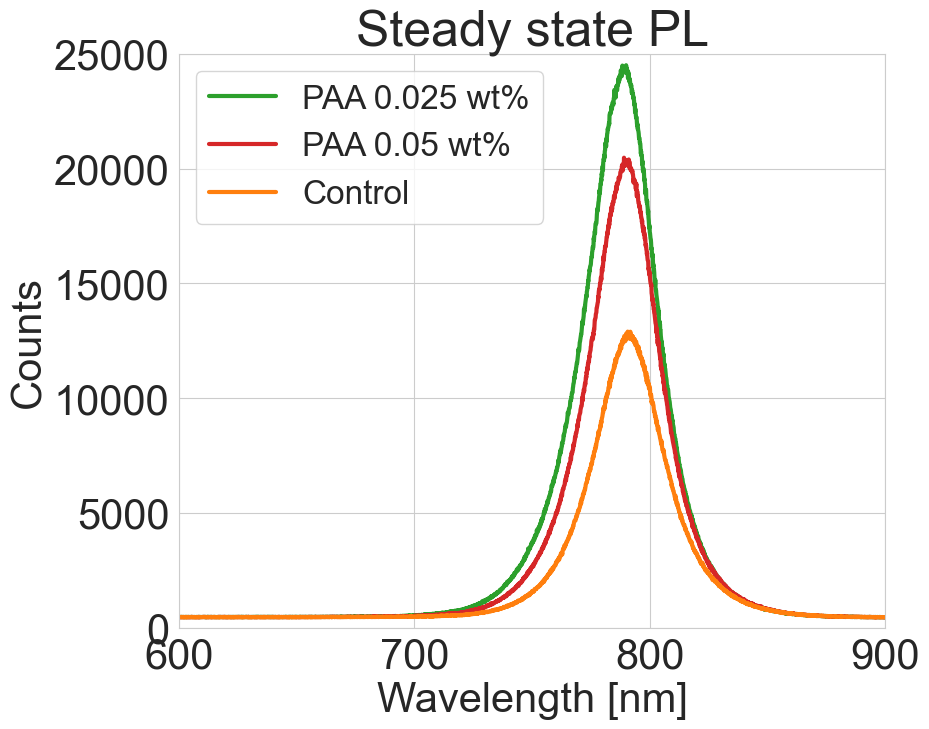

In [21]:
# Apply a default plot theme
sns.set_style("whitegrid")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot
sns.lineplot(data=PL[1], x="#Wave", y="#Intensity",
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PAA 0.025 wt%",
                ax=ax
                )

sns.lineplot(data=PL[2], x="#Wave", y="#Intensity",
                color=sns.color_palette("tab10")[3],
                lw=3,
                label="PAA 0.05 wt%",
                ax=ax
                )

sns.lineplot(data=PL[0], x="#Wave", y="#Intensity",
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="Control",
                ax=ax
                )

ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Counts")

ax.set_xlim([600, 900])
ax.set_ylim([0, 25000])

ax.legend(fontsize=24)
ax.set_title("Steady state PL")

# fileName = 'Steady state PL v2'
# save_figure(path_figure_folder, fileName, fig)

#### Extract peak positions

In [22]:
position = []
height = []
for spectra in PL:
    height.append(spectra["#Intensity"].max())
    position.append(spectra["#Wave"][spectra["#Intensity"].idxmax()])
    
print(position)
print(height)

[790.594507739039, 789.924090550816, 789.030061829059]
[12899, 24504, 20475]


### Time depended PL

In [23]:
# File paths
files = ["Control.CSV", "0.025% PAA.CSV", "0.05% PAA.CSV"]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "Time dependent PL")
path_data = [os.path.join(path_data_folder, file) for file in files]

# Read in data
PL = [pd.read_csv(path,  header= 8, sep=",") for path in path_data]

# Change name of the columns
[frame.rename(columns={"YAxis": "x", "Counts": "y"}, inplace=True) for frame in PL]

#Normalise the data
for spectra in PL:
    spectra["y"] = spectra["y"]/spectra["y"].max() 

#### Extracting lifetimes

In [24]:
tau_1 = []
tau_2 = []
A_1 = []
A_2 = []
start_time = []
parameters = []

def biexponential(x, A1, τ1, A2, τ2):
    return A1 * np.exp(-x / τ1) + A2 * np.exp(-x / τ2)

# Start analysis at the time for the maximum signal
for spectra in PL:
    # Starting point
    start = spectra["y"].idxmax()
    st = spectra["x"][start]
    start_time.append(st)
    
    # Start parameters
    p0=[100, 10, 100, 10]

    # Time offset
    temp = spectra.drop(range(0,spectra["y"].idxmax()))
    x = temp["x"].values - st
    y = temp["y"].values

    # Bi exponential fitting
    params, covariance = curve_fit(biexponential, x, y, p0=[1, 30, 1, 1000])
    
    parameters.append(params)
    tau_1.append(params[1])
    tau_2.append(params[3])
    A_1.append(params[0])
    A_2.append(params[2])

In [25]:
# The fitted parameters
with np.printoptions(precision=3, suppress=True):
    print(parameters[0])
    print(parameters[1])
    print(parameters[2])

[   0.287   22.045    0.707 1217.018]
[   0.27    21.595    0.643 2260.537]
[   0.259   29.133    0.699 1645.708]


#### Plotting data

Text(0.5, 1.0, 'Time Correlated SPC')

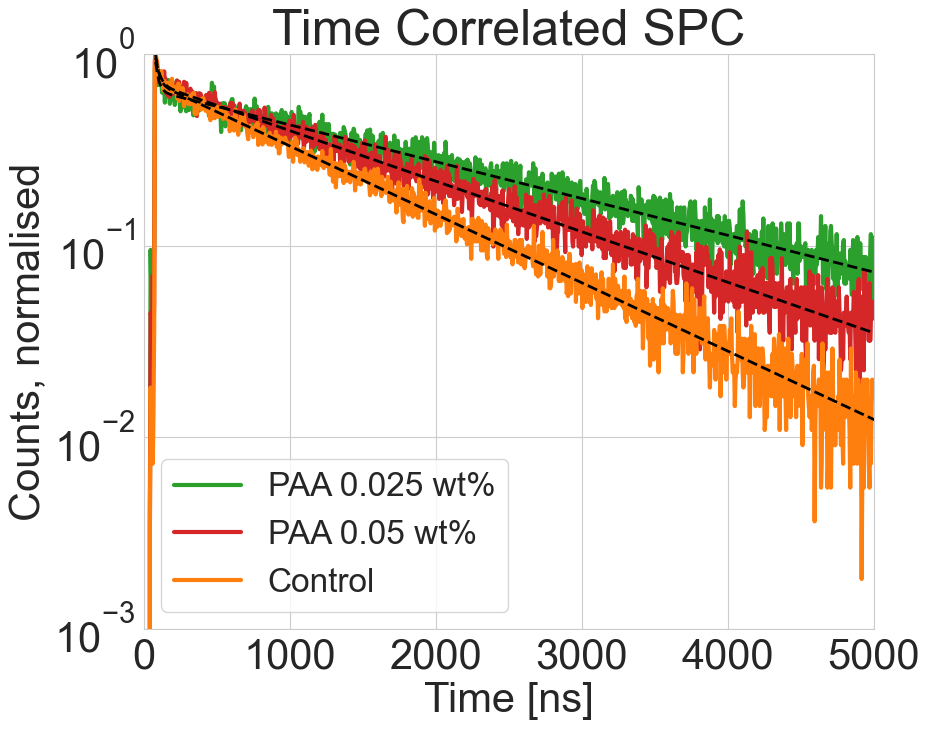

In [26]:
# Apply a default plot theme
sns.set_style("whitegrid")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot
sns.lineplot(data=PL[1], x="x", y="y",
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PAA 0.025 wt%",
                ax=ax
                )

sns.lineplot(data=PL[2], x="x", y="y",
                color=sns.color_palette("tab10")[3],
                lw=3,
                label="PAA 0.05 wt%",
                ax=ax
                )

sns.lineplot(data=PL[0], x="x", y="y",
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="Control",
                ax=ax
                )

# Plot fits
x = PL[0]["x"]
fit_values = biexponential(x, *parameters[0])
sns.lineplot(x=x + start_time[0], y=fit_values,
                color="black",
                lw=2,
                linestyle="--",
                ax=ax
                )

x = PL[1]["x"]
fit_values = biexponential(x, *parameters[1])
sns.lineplot(x=x + start_time[1], y=fit_values,
                color="black",
                lw=2,
                linestyle="--",
                ax=ax
                )

x = PL[2]["x"]
fit_values = biexponential(x, *parameters[2])
sns.lineplot(x=x + start_time[2], y=fit_values,
                color="black",
                lw=2,
                linestyle="--",
                ax=ax
                )

plt.yscale('log')

ax.set_xlabel("Time [ns]")
ax.set_ylabel("Counts, normalised")

ax.set_xlim([0, 5000])
ax.set_ylim([0.001, 1])

ax.legend(fontsize=24)
ax.set_title("Time Correlated SPC")

# fileName = 'Time dependent PL v2'
# save_figure(path_figure_folder, fileName, fig)

### Space charge current measurements

In [27]:
# File paths
files = ["Control-e-only.csv", "0.025%-PAA-e-only.csv", "Control-h-only.csv", "0.025%-PAA-h-only.csv"]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "SCLC")
path_data = [os.path.join(path_data_folder, file) for file in files]

# Read in data
SCLC = [pd.read_csv(path, header= 0,  sep=",") for path in path_data]

for df in SCLC:
    df["V_log"] = np.log10(df["V"])
    df["I_log"] = np.log10(df["I"])

c:\Users\jesja78\.conda\envs\chatgpt_manuscript\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jesja78\.conda\envs\chatgpt_manuscript\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jesja78\.conda\envs\chatgpt_manuscript\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jesja78\.conda\envs\chatgpt_manuscript\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jesja78\.conda\envs\chatgpt_manuscript\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs

In [31]:
# Determination of the transition region

# For the e-only devices, there is a sudden drop between the measurement points.
# The transition region is taken as the average between those two values.

# curve 1
# Reading from data. The transitions occurs between V=0.82 and V=0.84

# curve 2
# Reading from data. The transitions occurs between V=0.76 and V=0.78 

Text(0.5, 1.0, 'SCLC, e-only device')

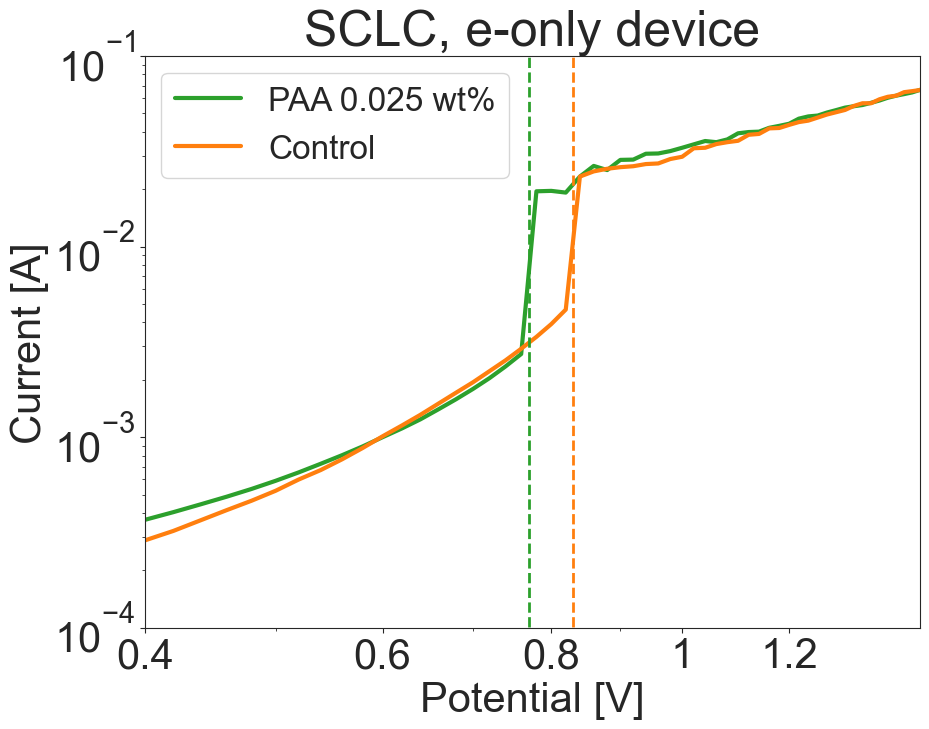

In [28]:
# Apply a default plot theme
sns.set_style("ticks")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot
sns.lineplot(data=SCLC[1], x="V", y="I",
                color=sns.color_palette("tab10")[2],
                lw=3,
                # s=100,
                label="PAA 0.025 wt%",
                ax=ax
                )

sns.lineplot(data=SCLC[0], x="V", y="I",
                color=sns.color_palette("tab10")[1],
                lw=3,
                # s=100,
                label="Control",
                ax=ax
                )

plt.plot([0.83, 0.83], [0, 1], linestyle="--", lw=2, color=sns.color_palette("tab10")[1],)
plt.plot([0.77, 0.77], [0, 1], linestyle="--", lw=2, color=sns.color_palette("tab10")[2],)

plt.xscale('log')
plt.yscale('log')

xticks = [0.4, 0.6, 0.8, 1, 1.2]  # Specify your desired x-ticks
plt.xticks(xticks, labels=[str(tick) for tick in xticks])

ax.set_xlim([0.4, 1.5])
ax.set_ylim([1e-4, 0.1])

ax.set_xlabel("Potential [V]")
ax.set_ylabel("Current [A]")

ax.legend(fontsize=24)

ax.set_title("SCLC, e-only device")

# fileName = 'SCLC e-only v2'
# save_figure(path_figure_folder, fileName, fig)

In [29]:
# Determination of the transition region
# For the h-only devices

# Control
temp = SCLC[2][SCLC[2]["V"].between(0.5, 0.7)].copy()
coef1 = np.polyfit(temp["V_log"], temp["I_log"], 1)
p1 = np.poly1d(coef1)
SCLC[2]["fit_1"] = 10**p1(np.log10(SCLC[2]["V"]))

temp = SCLC[2][SCLC[2]["V"].between(2, 3)].copy()
coef2 = np.polyfit(temp["V_log"], temp["I_log"], 1)
p2 = np.poly1d(coef2)
SCLC[2]["fit_2"] = 10**p2(np.log10(SCLC[2]["V"]))

#PAA
temp = SCLC[3][SCLC[3]["V"].between(0.5, 0.7)].copy()
coef3 = np.polyfit(temp["V_log"], temp["I_log"], 1)
p3 = np.poly1d(coef3)
SCLC[3]["fit_1"] = 10**p3(np.log10(SCLC[3]["V"]))

temp = SCLC[3][SCLC[3]["V"].between(2, 3)].copy()
coef4 = np.polyfit(temp["V_log"], temp["I_log"], 1)
p4 = np.poly1d(coef4)
SCLC[3]["fit_2"] = 10**p4(np.log10(SCLC[3]["V"]))

c:\Users\jesja78\.conda\envs\chatgpt_manuscript\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jesja78\.conda\envs\chatgpt_manuscript\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jesja78\.conda\envs\chatgpt_manuscript\Lib\site-packages\numpy\lib\polynomial.py:780: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv
c:\Users\jesja78\.conda\envs\chatgpt_manuscript\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jesja78\.conda\envs\chatgpt_manuscript\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jesja78\.conda\envs\cha

In [30]:
# Determine intercepts
intercept_1 = (coef2[1] - coef1[1])/(coef1[0] - coef2[0])
# Scale for logaritm
intercept_1 = 10**intercept_1

# Determine intercepts
intercept_2 = (coef4[1] - coef3[1])/(coef3[0] - coef4[0])
# Scale for logaritm
intercept_2 = 10**intercept_2

print(intercept_1)
print(intercept_2)

0.9929937512107139
0.9871069073347452


Text(0.5, 1.0, 'SCLC, h-only device')

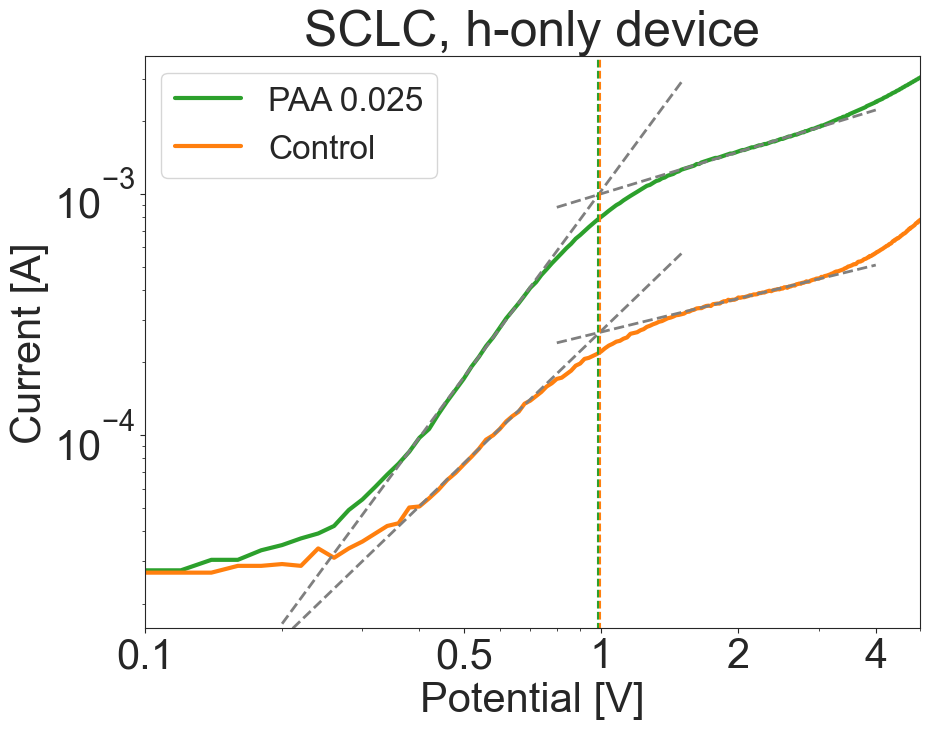

In [31]:
# Apply a default plot theme
sns.set_style("ticks")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot

g = sns.lineplot(data=SCLC[3], x="V", y="I",
                color=sns.color_palette("tab10")[2],
                lw=3,
                # s=100,
                label="PAA 0.025",
                ax=ax
                )

sns.lineplot(data=SCLC[2], x="V", y="I",
                color=sns.color_palette("tab10")[1],
                lw=3,
                # s=100,
                label="Control",
                ax=ax
                )



sns.lineplot(data=SCLC[2][SCLC[2]["V"].between(0.2, 1.5)], x="V", y="fit_1",
                color=sns.color_palette("tab10")[7],
                lw=2,
                # s=100,
                # label="PAA 0.025 wt%",
                linestyle="--",
                ax=ax
                )

sns.lineplot(data=SCLC[2][SCLC[2]["V"].between(0.8, 4)], x="V", y="fit_2",
                color=sns.color_palette("tab10")[7],
                lw=2,
                # s=100,
                # label="PAA 0.025 wt%",
                linestyle="--",
                ax=ax
                )

sns.lineplot(data=SCLC[3][SCLC[3]["V"].between(0.2, 1.5)], x="V", y="fit_1",
                color=sns.color_palette("tab10")[7],
                lw=2,
                # s=100,
                # label="PAA 0.025 wt%",
                linestyle="--",
                ax=ax
                )

sns.lineplot(data=SCLC[3][SCLC[3]["V"].between(0.8, 4)], x="V", y="fit_2",
                color=sns.color_palette("tab10")[7],
                lw=2,
                # s=100,
                # label="PAA 0.025 wt%",
                linestyle="--",
                ax=ax
                )


# plt.plot([1.02, 1.02], [0, 1], linestyle="--", color=sns.color_palette("tab10")[1],)
# plt.plot([1.12, 1.12], [0, 1], linestyle="--", color=sns.color_palette("tab10")[2],)

plt.plot([intercept_1, intercept_1], [0, 1], linestyle="--", color=sns.color_palette("tab10")[1],)
plt.plot([intercept_2, intercept_2], [0, 1], linestyle="--", color=sns.color_palette("tab10")[2],)

plt.xscale('log')
plt.yscale('log')

xticks = [0.1, 0.5, 1, 2, 4]  # Specify your desired x-ticks
plt.xticks(xticks, labels=[str(tick) for tick in xticks])

ax.set_xlim([0.1, 5])
ax.set_ylim([1e-4, 0.1])
ax.set_ylim([SCLC[2]["I"].min(), SCLC[3]["I"].max()])

ax.set_xlabel("Potential [V]")
ax.set_ylabel("Current [A]")

ax.legend(fontsize=24)

ax.set_title("SCLC, h-only device")

# fileName = 'SCLC h-only v2'
# save_figure(path_figure_folder, fileName, fig)

### XPS data

#### Read in data

In [32]:
# File paths
# files = ["control.xlsx", "ito+0.5%paa.xlsx", "0.25%PAA.xlsx", "0.5%PAA.xlsx"  ]
files = ["control.xlsx", "ito+0.5%PAA-2.xlsx", "0.25%PAA.xlsx", "0.5%PAA.xlsx"  ]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "XPS")
path_data = [os.path.join(path_data_folder, file) for file in files]

# Read in data for the N1s spectra
XPS_N1s = []

XPS_N1s_temp = pd.read_excel(path_data[0], sheet_name="N1s Scan A", header=15)
XPS_N1s_temp = XPS_N1s_temp.iloc[:,[0, 2, 4, 5, 6, 7]].copy()
col = XPS_N1s_temp.columns
XPS_N1s_temp.rename(columns={col[0]: "E", 
                    col[1]: "raw", 
                    col[2]: "signal", 
                    col[3]: "background", 
                    col[4]: "envelope", 
                    col[5]: "residuals"}, inplace=True)

XPS_N1s.append(XPS_N1s_temp)

# XPS_N1s_temp = pd.read_excel(path_data[1], sheet_name="N1s Scan A", header=15)
# XPS_N1s_temp = XPS_N1s_temp.iloc[:,[0, 2, 4, 5, 6, 7]].copy()
# col = XPS_N1s_temp.columns
# XPS_N1s_temp.rename(columns={col[0]: "E", 
#                     col[1]: "raw", 
#                     col[2]: "signal", 
#                     col[3]: "background", 
#                     col[4]: "envelope", 
#                     col[5]: "residuals"}, inplace=True)

XPS_N1s_temp = pd.read_excel(path_data[1], sheet_name="N1s Scan C", header=15)
XPS_N1s_temp = XPS_N1s_temp.iloc[:,[0, 2, 4, 5, 6, 7, 8]].copy()
col = XPS_N1s_temp.columns
XPS_N1s_temp.rename(columns={col[0]: "E", 
                    col[1]: "raw", 
                    col[2]: "signal_1", 
                    col[3]: "signal_2",          
                    col[4]: "background", 
                    col[5]: "envelope", 
                    col[6]: "residuals"}, inplace=True)

XPS_N1s.append(XPS_N1s_temp)

XPS_N1s_temp = pd.read_excel(path_data[2], sheet_name="N1s Scan A", header=15)
XPS_N1s_temp = XPS_N1s_temp.iloc[:,[0, 2, 4, 5, 6, 7, 8, 9]].copy()
col = XPS_N1s_temp.columns
XPS_N1s_temp.rename(columns={col[0]: "E", 
                    col[1]: "raw", 
                    col[2]: "signal_1", 
                    col[3]: "signal_2", 
                    col[4]: "signal_3", 
                    col[5]: "background", 
                    col[6]: "envelope", 
                    col[7]: "residuals"}, inplace=True)

XPS_N1s.append(XPS_N1s_temp)

XPS_N1s_temp = pd.read_excel(path_data[3], sheet_name="N1s Scan A", header=15)
XPS_N1s_temp = XPS_N1s_temp.iloc[:,[0, 2, 4, 5, 6, 7, 8, 9]].copy()
col = XPS_N1s_temp.columns
XPS_N1s_temp.rename(columns={col[0]: "E", 
                    col[1]: "raw", 
                    col[2]: "signal_1", 
                    col[3]: "signal_2", 
                    col[4]: "signal_3", 
                    col[5]: "background", 
                    col[6]: "envelope", 
                    col[7]: "residuals"}, inplace=True)

XPS_N1s.append(XPS_N1s_temp)

#### Extracting peak positions

In [33]:
# Control sample
peak_pos_control = XPS_N1s[0]["E"][XPS_N1s[0]["signal"].idxmax()]
# peak_pos_PAA_ITO = XPS_N1s[1]["E"][XPS_N1s[1]["signal"].idxmax()]
XPS_N1s_temp = XPS_N1s[1][XPS_N1s[2]["E"]<404]
peak_pos_PAA_ITO_1 = XPS_N1s_temp["E"][XPS_N1s_temp["signal_1"].idxmax()]
peak_pos_PAA_ITO_2 = XPS_N1s_temp["E"][XPS_N1s_temp["signal_2"].idxmax()]

XPS_N1s_temp = XPS_N1s[2][XPS_N1s[2]["E"]<404]
peak_pos_PAA_025_1 = XPS_N1s_temp["E"][XPS_N1s_temp["signal_1"].idxmax()]
peak_pos_PAA_025_2 = XPS_N1s_temp["E"][XPS_N1s_temp["signal_2"].idxmax()]
XPS_N1s_temp = XPS_N1s[2][XPS_N1s[2]["E"]<400]
peak_pos_PAA_025_3 = XPS_N1s_temp["E"][XPS_N1s_temp["signal_3"].idxmax()]

XPS_N1s_temp = XPS_N1s[3][XPS_N1s[3]["E"]<404]
peak_pos_PAA_05_1 = XPS_N1s_temp["E"][XPS_N1s_temp["signal_1"].idxmax()]
peak_pos_PAA_05_2 = XPS_N1s_temp["E"][XPS_N1s_temp["signal_2"].idxmax()]
peak_pos_PAA_05_3 = XPS_N1s_temp["E"][XPS_N1s_temp["signal_3"].idxmax()]

#### Combined figure

[[Text(0, -2500.0, ''),
  Text(0, 0.0, ''),
  Text(0, 2500.0, ''),
  Text(0, 5000.0, ''),
  Text(0, 7500.0, ''),
  Text(0, 10000.0, ''),
  Text(0, 12500.0, ''),
  Text(0, 15000.0, ''),
  Text(0, 17500.0, ''),
  Text(0, 20000.0, '')]]

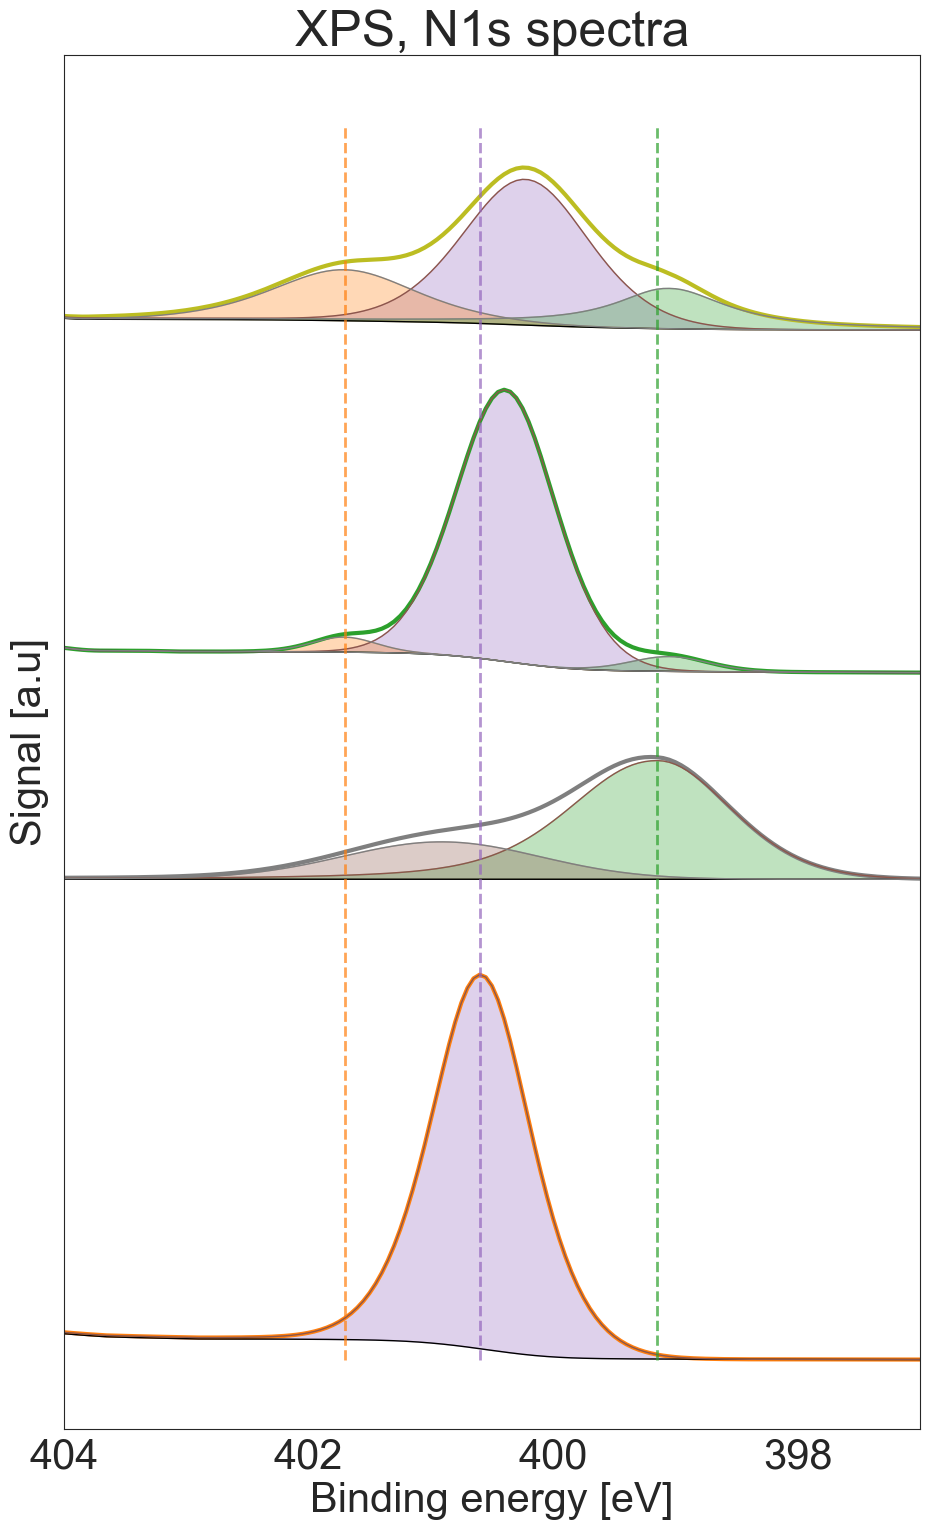

In [34]:
# Plot combined image of N1s spectrum
offsets = [0, 7000, 10000, 15000]

# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 16), tight_layout=True)

# Generate a line plot
# Control
l_0 = sns.lineplot(x=XPS_N1s[0]["E"], 
             y=XPS_N1s[0]["envelope"] - XPS_N1s[0]["envelope"].min(), 
            color=sns.color_palette("tab10")[1],
            lw=3,
            label="Control",
            ax=ax
            )

l_1 = sns.lineplot(x=XPS_N1s[0]["E"], 
             y=XPS_N1s[0]["background"] - XPS_N1s[0]["envelope"].min(), 
            color="black",
            lw=1,
            ax=ax
            )

l_2 = sns.lineplot(x=XPS_N1s[0]["E"], 
             y=XPS_N1s[0]["signal"] - XPS_N1s[0]["envelope"].min(), 
            color=sns.color_palette("tab10")[5],
            lw=1,
            ax=ax
            )


# PAA on ITO
l_3 = sns.lineplot(x=XPS_N1s[1]["E"], 
             y=XPS_N1s[1]["envelope"] - XPS_N1s[1]["envelope"].min() + offsets[1], 
            color=sns.color_palette("tab10")[7],
            lw=3,
            label="PAA on ITO",
            ax=ax
            )

l_4 = sns.lineplot(x=XPS_N1s[1]["E"], 
             y=XPS_N1s[1]["background"] - XPS_N1s[1]["envelope"].min() + offsets[1], 
            color="black",
            lw=1,
            ax=ax
            )

# l_5 = sns.lineplot(x=XPS_N1s[1]["E"], 
#              y=XPS_N1s[1]["signal"] - XPS_N1s[1]["envelope"].min() + offsets[1], 
#             color="black",
#             lw=1,
#             ax=ax
#             )


# 0.025 PAA on Perovskite
l_5 = sns.lineplot(x=XPS_N1s[2]["E"], 
             y=XPS_N1s[2]["envelope"] - XPS_N1s[2]["envelope"].min() + offsets[2], 
            color=sns.color_palette("tab10")[2],
            lw=3,
            label="PAA 0.025",
            ax=ax
            )

l_6 = sns.lineplot(x=XPS_N1s[2]["E"], 
             y=XPS_N1s[2]["background"] - XPS_N1s[2]["envelope"].min() + offsets[2], 
            color="black",
            lw=1,
            ax=ax
            )

l_7 = sns.lineplot(x=XPS_N1s[2]["E"], 
             y=XPS_N1s[2]["signal_1"] - XPS_N1s[2]["envelope"].min() + offsets[2], 
            color=sns.color_palette("tab10")[5],
            lw=1,
            ax=ax
            )

l_8 = sns.lineplot(x=XPS_N1s[2]["E"], 
             y=XPS_N1s[2]["signal_2"] - XPS_N1s[2]["envelope"].min() + offsets[2], 
            color=sns.color_palette("tab10")[7],
            lw=1,
            ax=ax
            )

l_9 = sns.lineplot(x=XPS_N1s[2]["E"], 
             y=XPS_N1s[2]["signal_3"] - XPS_N1s[2]["envelope"].min() + offsets[2], 
            color=sns.color_palette("tab10")[7],
            lw=1,
            ax=ax
            )

# 0.05 PAA on Perovskite
l_10 = sns.lineplot(x=XPS_N1s[3]["E"], 
             y=XPS_N1s[3]["envelope"] - XPS_N1s[3]["envelope"].min() + offsets[3], 
            color=sns.color_palette("tab10")[8],
            lw=3,
            label="PAA 0.5",
            ax=ax
            )

l_11 = sns.lineplot(x=XPS_N1s[3]["E"], 
             y=XPS_N1s[3]["background"] - XPS_N1s[3]["envelope"].min() + offsets[3], 
            color="black",
            lw=1,
            ax=ax
            )

l_12 = sns.lineplot(x=XPS_N1s[3]["E"], 
             y=XPS_N1s[3]["signal_1"] - XPS_N1s[3]["envelope"].min() + offsets[3], 
            color=sns.color_palette("tab10")[5],
            lw=1,
            ax=ax
            )

l_13 = sns.lineplot(x=XPS_N1s[3]["E"], 
             y=XPS_N1s[3]["signal_2"] - XPS_N1s[3]["envelope"].min() + offsets[3], 
            color=sns.color_palette("tab10")[7],
            lw=1,
            ax=ax
            )

l_14 = sns.lineplot(x=XPS_N1s[3]["E"], 
             y=XPS_N1s[3]["signal_3"] - XPS_N1s[3]["envelope"].min() + offsets[3], 
            color=sns.color_palette("tab10")[7],
            lw=1,
            ax=ax
            )

# PAA on ITO signal
l_15 = sns.lineplot(x=XPS_N1s[1]["E"], 
             y=XPS_N1s[1]["signal_1"] - XPS_N1s[1]["envelope"].min() + offsets[1], 
            color=sns.color_palette("tab10")[5],
            lw=1,
            ax=ax
            )
l_16 = sns.lineplot(x=XPS_N1s[1]["E"], 
             y=XPS_N1s[1]["signal_2"] - XPS_N1s[1]["envelope"].min() + offsets[1], 
            color=sns.color_palette("tab10")[7],
            lw=1,
            ax=ax
            )

line = l_14.get_lines()

plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color=sns.color_palette("tab10")[4], alpha=0.3)
# plt.fill_between(line[3].get_xdata(), line[4].get_ydata(), line[3].get_ydata(), color=sns.color_palette("tab10")[2], alpha=0.3)
plt.fill_between(line[5].get_xdata(), line[6].get_ydata(), line[7].get_ydata(), color=sns.color_palette("tab10")[4], alpha=0.3)
plt.fill_between(line[5].get_xdata(), line[6].get_ydata(), line[8].get_ydata(), color=sns.color_palette("tab10")[1], alpha=0.3)
plt.fill_between(line[5].get_xdata(), line[6].get_ydata(), line[9].get_ydata(), color=sns.color_palette("tab10")[2], alpha=0.3)
plt.fill_between(line[10].get_xdata(), line[11].get_ydata(), line[12].get_ydata(), color=sns.color_palette("tab10")[4], alpha=0.3)
plt.fill_between(line[10].get_xdata(), line[11].get_ydata(), line[13].get_ydata(), color=sns.color_palette("tab10")[1], alpha=0.3)
plt.fill_between(line[10].get_xdata(), line[11].get_ydata(), line[14].get_ydata(), color=sns.color_palette("tab10")[2], alpha=0.3)

plt.fill_between(line[4].get_xdata(), line[15].get_ydata(), line[4].get_ydata(), color=sns.color_palette("tab10")[2], alpha=0.3)
plt.fill_between(line[4].get_xdata(), line[16].get_ydata(), line[4].get_ydata(), color=sns.color_palette("tab10")[5], alpha=0.3)

plt.plot([peak_pos_control, peak_pos_control], [0, 18000], linestyle="--", lw=2, color=sns.color_palette("tab10")[4], alpha=0.7)
plt.plot([peak_pos_PAA_ITO_1, peak_pos_PAA_ITO_1], [0, 18000], linestyle="--", lw=2, color=sns.color_palette("tab10")[2], alpha=0.7)
plt.plot([peak_pos_PAA_05_2, peak_pos_PAA_05_2], [0, 18000], linestyle="--", lw=2, color=sns.color_palette("tab10")[1], alpha=0.7)

ax.set_xlim([397, 404])
ax.set_ylim(bottom=-1000, top=19000)

plt.gca().invert_xaxis()

ax.set_xlabel("Binding energy [eV]")
ax.set_ylabel("Signal [a.u]")
ax.set_title("XPS, N1s spectra")

ax.legend(fontsize=24)
ax.get_legend().set_visible(False)
ax.set(yticklabels=[])

# fileName = 'XPS combined figure v3'
# save_figure(path_figure_folder, fileName, fig)

#### Individual XPS figures

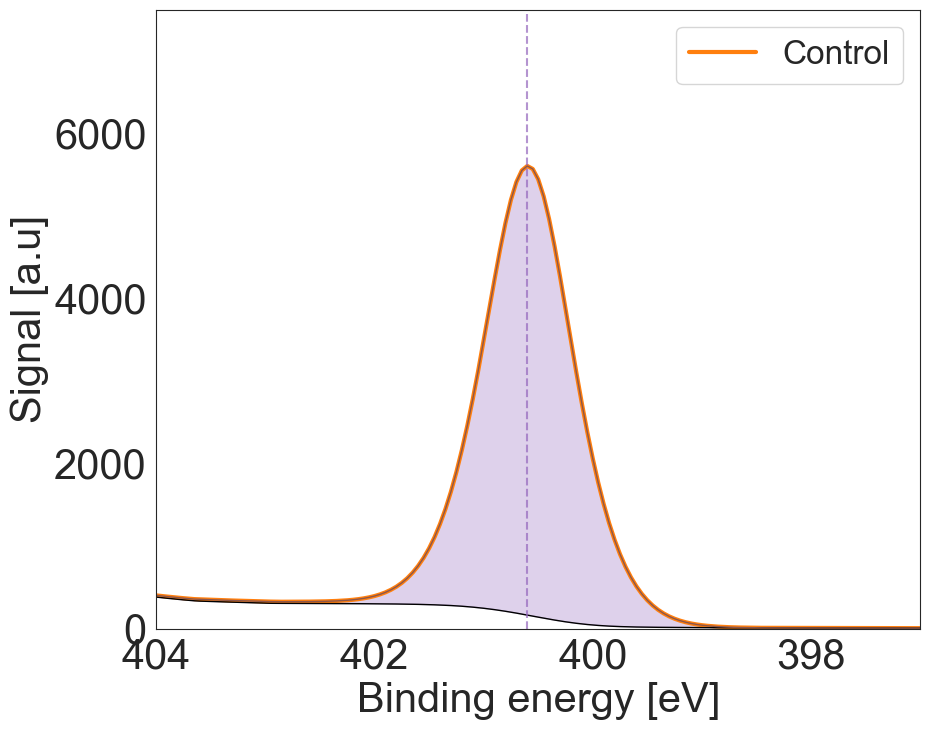

In [35]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Control
l_0 = sns.lineplot(x=XPS_N1s[0]["E"], 
             y=XPS_N1s[0]["envelope"] - XPS_N1s[0]["envelope"].min(), 
            color=sns.color_palette("tab10")[1],
            lw=3,
            label="Control",
            ax=ax
            )

l_1 = sns.lineplot(x=XPS_N1s[0]["E"], 
             y=XPS_N1s[0]["background"] - XPS_N1s[0]["envelope"].min(), 
            color="black",
            lw=1,
            ax=ax
            )

l_2 = sns.lineplot(x=XPS_N1s[0]["E"], 
             y=XPS_N1s[0]["signal"] - XPS_N1s[0]["envelope"].min(), 
            color=sns.color_palette("tab10")[5],
            lw=1,
            ax=ax
            )

line = l_14.get_lines()

plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color=sns.color_palette("tab10")[4], alpha=0.3)

plt.plot([peak_pos_control, peak_pos_control], [0, 18000], linestyle="--", color=sns.color_palette("tab10")[4], alpha=0.7)

ax.set_xlim([397, 404])
ax.set_ylim(bottom=0, top=7500)

plt.gca().invert_xaxis()

ax.set_xlabel("Binding energy [eV]")
ax.set_ylabel("Signal [a.u]")

ax.legend(fontsize=24)

# fileName = 'XPS control figure v1'
# save_figure(path_figure_folder, fileName, fig)

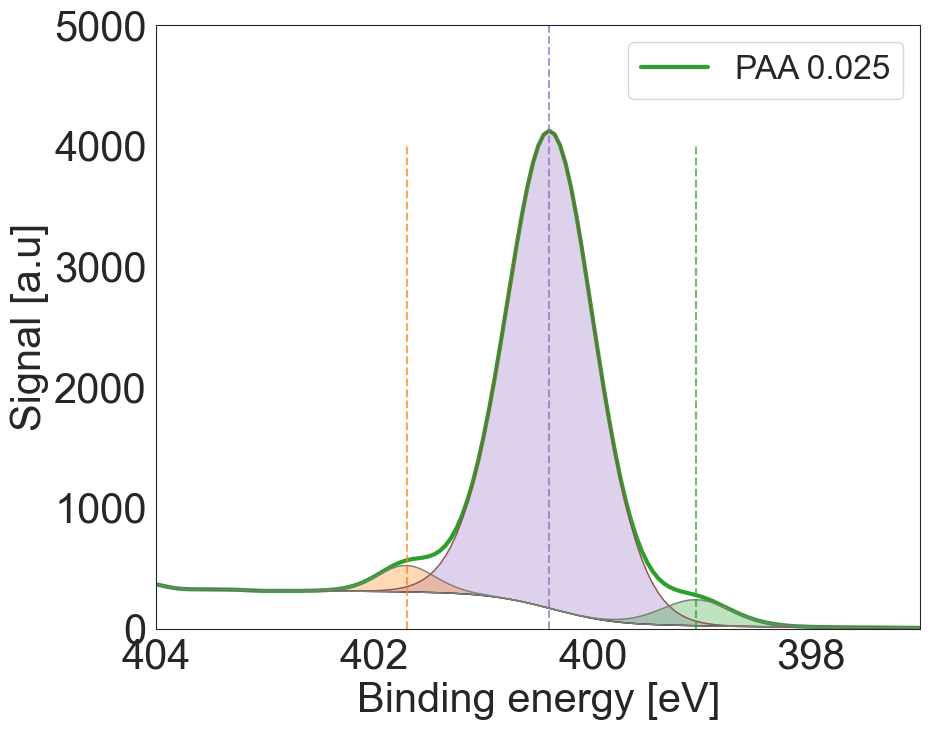

In [295]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# 0.025 PAA on Perovskite
l_5 = sns.lineplot(x=XPS_N1s[2]["E"], 
             y=XPS_N1s[2]["envelope"] - XPS_N1s[2]["envelope"].min(), 
            color=sns.color_palette("tab10")[2],
            lw=3,
            label="PAA 0.025",
            ax=ax
            )

l_6 = sns.lineplot(x=XPS_N1s[2]["E"], 
             y=XPS_N1s[2]["background"] - XPS_N1s[2]["envelope"].min(), 
            color="black",
            lw=1,
            ax=ax
            )

l_7 = sns.lineplot(x=XPS_N1s[2]["E"], 
             y=XPS_N1s[2]["signal_1"] - XPS_N1s[2]["envelope"].min(), 
            color=sns.color_palette("tab10")[5],
            lw=1,
            ax=ax
            )

l_8 = sns.lineplot(x=XPS_N1s[2]["E"], 
             y=XPS_N1s[2]["signal_2"] - XPS_N1s[2]["envelope"].min(), 
            color=sns.color_palette("tab10")[7],
            lw=1,
            ax=ax
            )

l_9 = sns.lineplot(x=XPS_N1s[2]["E"], 
             y=XPS_N1s[2]["signal_3"] - XPS_N1s[2]["envelope"].min(), 
            color=sns.color_palette("tab10")[7],
            lw=1,
            ax=ax
            )

line = l_9.get_lines()

plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color=sns.color_palette("tab10")[4], alpha=0.3)
plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[3].get_ydata(), color=sns.color_palette("tab10")[1], alpha=0.3)
plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[4].get_ydata(), color=sns.color_palette("tab10")[2], alpha=0.3)

ax.set_xlim([397, 404])
ax.set_ylim(bottom=0, top=5000)

plt.gca().invert_xaxis()

ax.set_xlabel("Binding energy [eV]")
ax.set_ylabel("Signal [a.u]")

ax.legend(fontsize=24)

plt.plot([peak_pos_PAA_025_1, peak_pos_PAA_025_1], [0, 18000], linestyle="--", color=sns.color_palette("tab10")[4], alpha=0.7)
plt.plot([peak_pos_PAA_025_2, peak_pos_PAA_025_2], [0, 4000], linestyle="--", color=sns.color_palette("tab10")[1], alpha=0.7)
plt.plot([peak_pos_PAA_025_3, peak_pos_PAA_025_3], [0, 4000], linestyle="--", color=sns.color_palette("tab10")[2], alpha=0.7)

# fileName = 'XPS PAA 0025 figure v1'
# save_figure(path_figure_folder, fileName, fig)

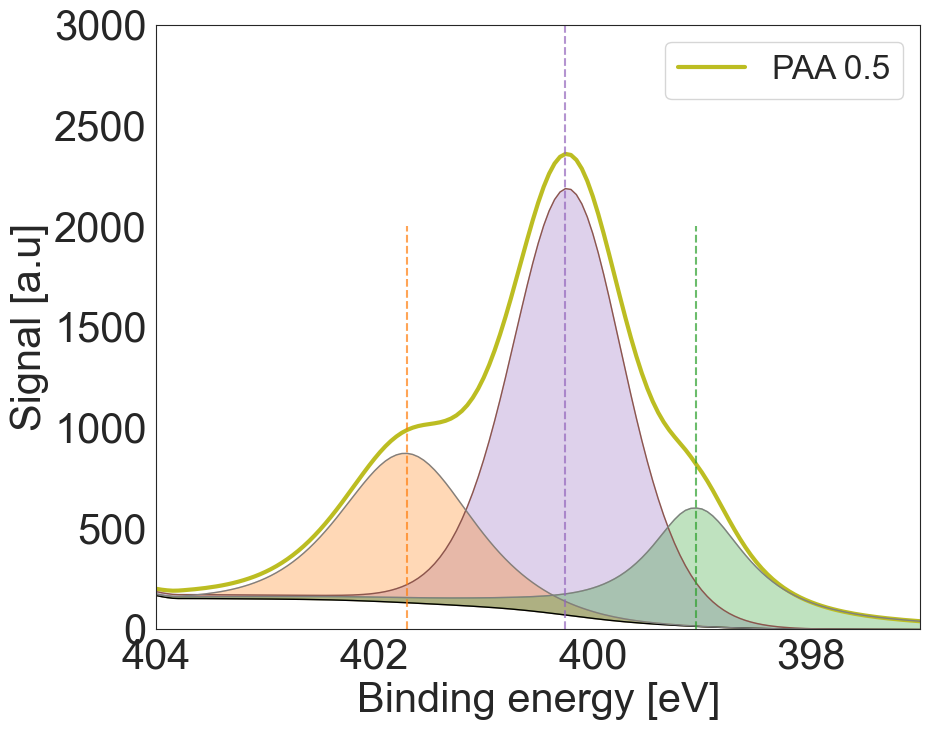

In [294]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

l_10 = sns.lineplot(x=XPS_N1s[3]["E"], 
             y=XPS_N1s[3]["envelope"] - XPS_N1s[3]["envelope"].min(), 
            color=sns.color_palette("tab10")[8],
            lw=3,
            label="PAA 0.5",
            ax=ax
            )

l_11 = sns.lineplot(x=XPS_N1s[3]["E"], 
             y=XPS_N1s[3]["background"] - XPS_N1s[3]["envelope"].min(), 
            color="black",
            lw=1,
            ax=ax
            )

l_12 = sns.lineplot(x=XPS_N1s[3]["E"], 
             y=XPS_N1s[3]["signal_1"] - XPS_N1s[3]["envelope"].min(), 
            color=sns.color_palette("tab10")[5],
            lw=1,
            ax=ax
            )

l_13 = sns.lineplot(x=XPS_N1s[3]["E"], 
             y=XPS_N1s[3]["signal_2"] - XPS_N1s[3]["envelope"].min(), 
            color=sns.color_palette("tab10")[7],
            lw=1,
            ax=ax
            )

l_14 = sns.lineplot(x=XPS_N1s[3]["E"], 
             y=XPS_N1s[3]["signal_3"] - XPS_N1s[3]["envelope"].min(), 
            color=sns.color_palette("tab10")[7],
            lw=1,
            ax=ax
            )


line = l_14.get_lines()

plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color=sns.color_palette("tab10")[4], alpha=0.3)
plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[3].get_ydata(), color=sns.color_palette("tab10")[1], alpha=0.3)
plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[4].get_ydata(), color=sns.color_palette("tab10")[2], alpha=0.3)

ax.set_xlim([397, 404])
ax.set_ylim(bottom=0, top=3000)

plt.gca().invert_xaxis()

ax.set_xlabel("Binding energy [eV]")
ax.set_ylabel("Signal [a.u]")

ax.legend(fontsize=24)

plt.plot([peak_pos_PAA_05_1, peak_pos_PAA_05_1], [0, 18000], linestyle="--", color=sns.color_palette("tab10")[4], alpha=0.7)
plt.plot([peak_pos_PAA_05_2, peak_pos_PAA_05_2], [0, 2000], linestyle="--", color=sns.color_palette("tab10")[1], alpha=0.7)
plt.plot([peak_pos_PAA_05_3, peak_pos_PAA_05_3], [0, 2000], linestyle="--", color=sns.color_palette("tab10")[2], alpha=0.7)

# fileName = 'XPS PAA 05 figure v1'
# save_figure(path_figure_folder, fileName, fig)

#### XPS I3d spectra

In [19]:
# File paths
files = ["control.xlsx", "0.25%PAA.xlsx", "0.5%PAA.xlsx"  ]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "XPS")
path_data = [os.path.join(path_data_folder, file) for file in files]

# Read in data for the N1s spectra
XPS_I3d = []

for path in path_data:
    XPS_I3d_temp = pd.read_excel(path, sheet_name="I3d Scan A", header=15)
    XPS_I3d_temp = XPS_I3d_temp.iloc[:,[0, 2, 4, 5, 6, 7, 8]].copy()
    col = XPS_I3d_temp.columns
    XPS_I3d_temp.rename(columns={col[0]: "E", 
                        col[1]: "raw", 
                        col[2]: "signal_1",
                        col[3]: "signal_2",  
                        col[4]: "background", 
                        col[5]: "envelope", 
                        col[6]: "residuals"}, inplace=True)

    XPS_I3d.append(XPS_I3d_temp)

In [20]:
# Peak positions
control_peak_1 = XPS_I3d[0]["E"][XPS_I3d[0]["signal_1"].idxmax()]
control_peak_2 = XPS_I3d[0]["E"][XPS_I3d[0]["signal_2"].idxmax()]

PAA_025_1_peak_1 = XPS_I3d[1]["E"][XPS_I3d[1]["signal_1"].idxmax()]
PAA_025_1_peak_2 = XPS_I3d[1]["E"][XPS_I3d[1]["signal_2"].idxmax()]

PAA_05_1_peak_1 = XPS_I3d[2]["E"][XPS_I3d[2]["signal_1"].idxmax()]
PAA_05_1_peak_2 = XPS_I3d[2]["E"][XPS_I3d[2]["signal_2"].idxmax()]

print([control_peak_1, PAA_025_1_peak_1, PAA_05_1_peak_1])
print([control_peak_2, PAA_025_1_peak_2, PAA_05_1_peak_2])

[619.25, 619.05, 618.85]
[630.75, 630.55, 630.35]


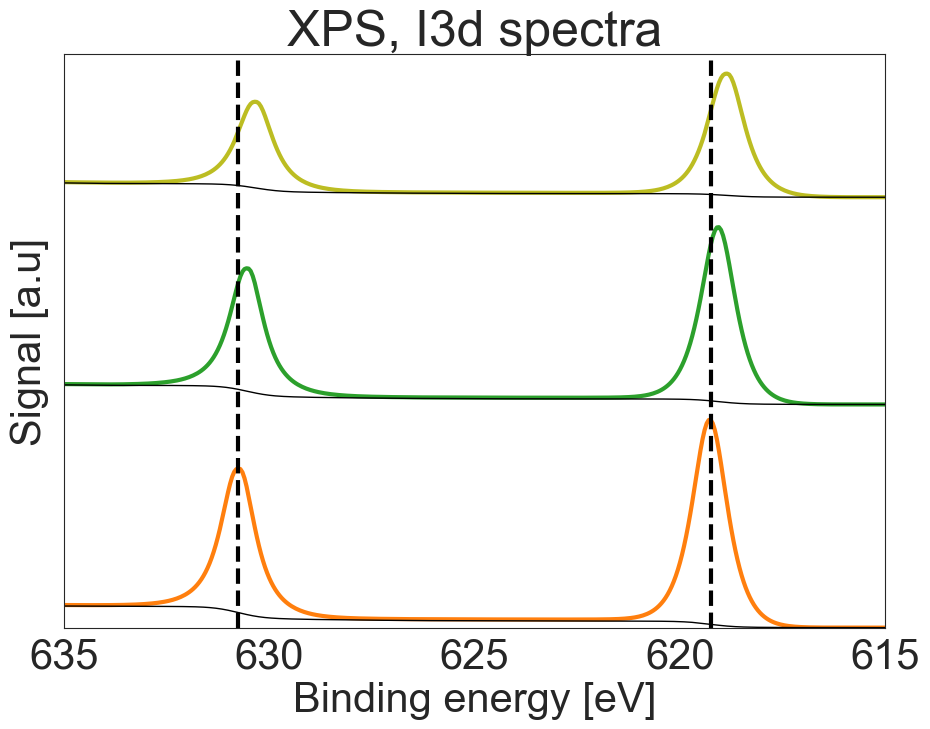

In [21]:
# Plot combined image of N1s spectrum
offsets = [0, 140000, 270000]

# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

l_0 = sns.lineplot(x=XPS_I3d[0]["E"], 
             y=XPS_I3d[0]["envelope"] - XPS_I3d[0]["envelope"].min() + offsets[0], 
            color=sns.color_palette("tab10")[1],
            lw=3,
            label="Control",
            ax=ax
            )

l_1 = sns.lineplot(x=XPS_I3d[0]["E"], 
             y=XPS_I3d[0]["background"] - XPS_I3d[0]["envelope"].min() + offsets[0], 
            color="black",
            lw=1,
            ax=ax
            )
l_2 = sns.lineplot(x=XPS_I3d[1]["E"], 
             y=XPS_I3d[1]["envelope"] - XPS_I3d[1]["envelope"].min() + offsets[1], 
            color=sns.color_palette("tab10")[2],
            lw=3,
            label="PAA 0.025 %",
            ax=ax
            )

l_3 = sns.lineplot(x=XPS_I3d[1]["E"], 
             y=XPS_I3d[1]["background"] - XPS_I3d[1]["envelope"].min() + offsets[1], 
            color="black",
            lw=1,
            ax=ax
            )

l_4 = sns.lineplot(x=XPS_I3d[2]["E"], 
             y=XPS_I3d[2]["envelope"] - XPS_I3d[2]["envelope"].min() + offsets[2], 
            color=sns.color_palette("tab10")[8],
            lw=3,
            label="PAA 0.5 %",
            ax=ax
            )

l_5 = sns.lineplot(x=XPS_I3d[2]["E"], 
             y=XPS_I3d[2]["background"] - XPS_I3d[2]["envelope"].min() + offsets[2], 
            color="black",
            lw=1,
            ax=ax
            )


plt.plot([control_peak_1, control_peak_1], [0, 360000], lw=3, linestyle="--", color="black", alpha=1)
plt.plot([control_peak_2, control_peak_2], [0, 360000],  lw=3, linestyle="--", color="black", alpha=1)

ax.set_xlim([615, 635])
ax.set_ylim(bottom=0, top=360000)

plt.gca().invert_xaxis()

ax.set_xlabel("Binding energy [eV]")
ax.set_ylabel("Signal [a.u]")

ax.legend(fontsize=24)
ax.get_legend().set_visible(False)
ax.set(yticklabels=[])

ax.set_title("XPS, I3d spectra")

# fileName = 'XPS I3d combined figure v2'
# save_figure(path_figure_folder, fileName, fig)

#### Pb4f spectra

In [333]:
# File paths
files = ["control.xlsx", "0.25%PAA.xlsx", "0.5%PAA.xlsx"  ]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "XPS")
path_data = [os.path.join(path_data_folder, file) for file in files]

# Read in data for the N1s spectra
XPS_PB4f = []

for path in path_data:
    XPS_PB4f_temp = pd.read_excel(path, sheet_name="Pb4f Scan A", header=15)
    XPS_PB4f_temp = XPS_PB4f_temp.iloc[:,[0, 2, 4, 5, 6, 7, 8]].copy()
    col = XPS_PB4f_temp.columns
    XPS_PB4f_temp.rename(columns={col[0]: "E", 
                        col[1]: "raw", 
                        col[2]: "signal_1",
                        col[3]: "signal_2",  
                        col[4]: "background", 
                        col[5]: "envelope", 
                        col[6]: "residuals"}, inplace=True)

    XPS_PB4f.append(XPS_PB4f_temp)

In [334]:
# Peak positions
control_peak_1 = XPS_PB4f[0]["E"][XPS_PB4f[0]["signal_1"].idxmax()]
control_peak_2 = XPS_PB4f[0]["E"][XPS_PB4f[0]["signal_2"].idxmax()]

PAA_025_1_peak_1 = XPS_PB4f[1]["E"][XPS_PB4f[1]["signal_1"].idxmax()]
PAA_025_1_peak_2 = XPS_PB4f[1]["E"][XPS_PB4f[1]["signal_2"].idxmax()]

PAA_05_1_peak_1 = XPS_PB4f[2]["E"][XPS_PB4f[2]["signal_1"].idxmax()]
PAA_05_1_peak_2 = XPS_PB4f[2]["E"][XPS_PB4f[2]["signal_2"].idxmax()]

print([control_peak_1, PAA_025_1_peak_1, PAA_05_1_peak_1])
print([control_peak_2, PAA_025_1_peak_2, PAA_05_1_peak_2])

[138.35, 138.3, 138.3]
[143.2, 143.15, 143.15]


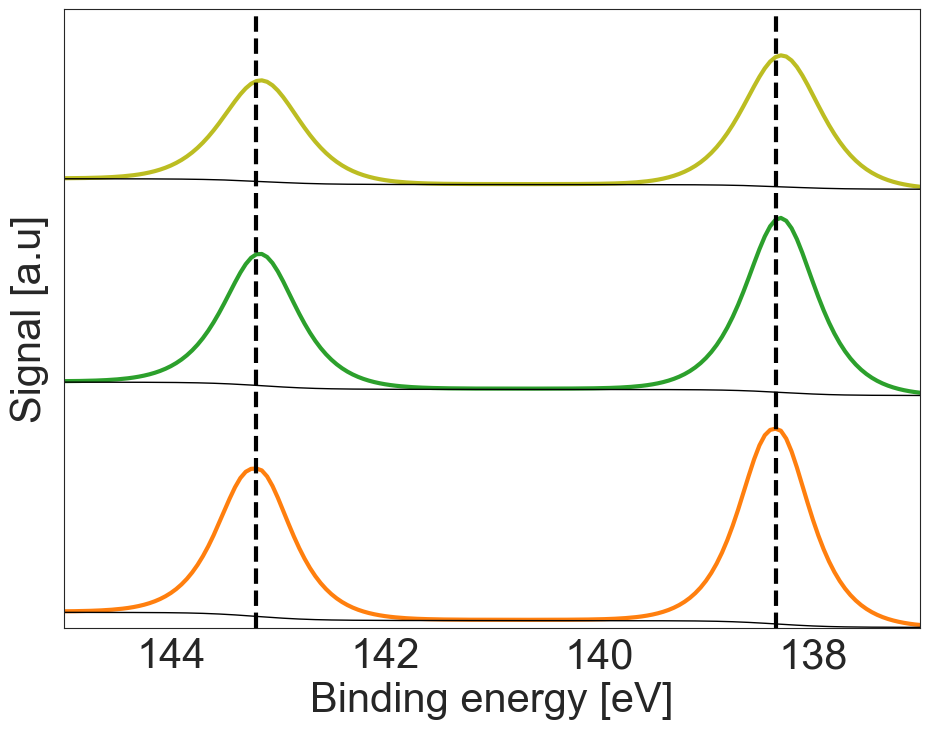

In [344]:
# Plot combined image of N1s spectrum
offsets = [0, 45000, 85000]

# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

l_0 = sns.lineplot(x=XPS_PB4f[0]["E"], 
             y=XPS_PB4f[0]["envelope"] - XPS_PB4f[0]["envelope"].min() + offsets[0], 
            color=sns.color_palette("tab10")[1],
            lw=3,
            label="Control",
            ax=ax
            )

l_1 = sns.lineplot(x=XPS_PB4f[0]["E"], 
             y=XPS_PB4f[0]["background"] - XPS_PB4f[0]["envelope"].min() + offsets[0], 
            color="black",
            lw=1,
            ax=ax
            )
l_2 = sns.lineplot(x=XPS_PB4f[1]["E"], 
             y=XPS_PB4f[1]["envelope"] - XPS_PB4f[1]["envelope"].min() + offsets[1], 
            color=sns.color_palette("tab10")[2],
            lw=3,
            label="PAA 0.025 %",
            ax=ax
            )

l_3 = sns.lineplot(x=XPS_PB4f[1]["E"], 
             y=XPS_PB4f[1]["background"] - XPS_PB4f[1]["envelope"].min() + offsets[1], 
            color="black",
            lw=1,
            ax=ax
            )

l_4 = sns.lineplot(x=XPS_PB4f[2]["E"], 
             y=XPS_PB4f[2]["envelope"] - XPS_PB4f[2]["envelope"].min() + offsets[2], 
            color=sns.color_palette("tab10")[8],
            lw=3,
            label="PAA 0.5 %",
            ax=ax
            )

l_5 = sns.lineplot(x=XPS_PB4f[2]["E"], 
             y=XPS_PB4f[2]["background"] - XPS_PB4f[2]["envelope"].min() + offsets[2], 
            color="black",
            lw=1,
            ax=ax
            )


plt.plot([control_peak_1, control_peak_1], [0, 360000], lw=3, linestyle="--", color="black", alpha=1)
plt.plot([control_peak_2, control_peak_2], [0, 360000],  lw=3, linestyle="--", color="black", alpha=1)

ax.set_xlim([137, 145])
ax.set_ylim(bottom=0, top=120000)

plt.gca().invert_xaxis()

ax.set_xlabel("Binding energy [eV]")
ax.set_ylabel("Signal [a.u]")

ax.legend(fontsize=24)
ax.get_legend().set_visible(False)
ax.set(yticklabels=[])

# fileName = 'XPS Pb4f combined figure v1'
# save_figure(path_figure_folder, fileName, fig)

### IV data

In [50]:
# File paths
files = ["CC-0009_231228_1_control.csv", "CC-0006_231228_1_0.025%PAA.csv", "CC-0001_231225_1_0.05%PAA.csv", "CC-0005_231228_1_IPA.csv",]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "IV", "champion devices under condition 4")
path_data = [os.path.join(path_data_folder, file) for file in files]

# Read in data for forward and reversed scan in separate dataframes
IV_rev = [pd.read_csv(path, header=8, nrows =132) for path in path_data]
IV_for = [pd.read_csv(path, header=141) for path in path_data]

#### Champion devices recipie 4

Text(0.5, 1.0, 'Champion devices. Recipe 4')

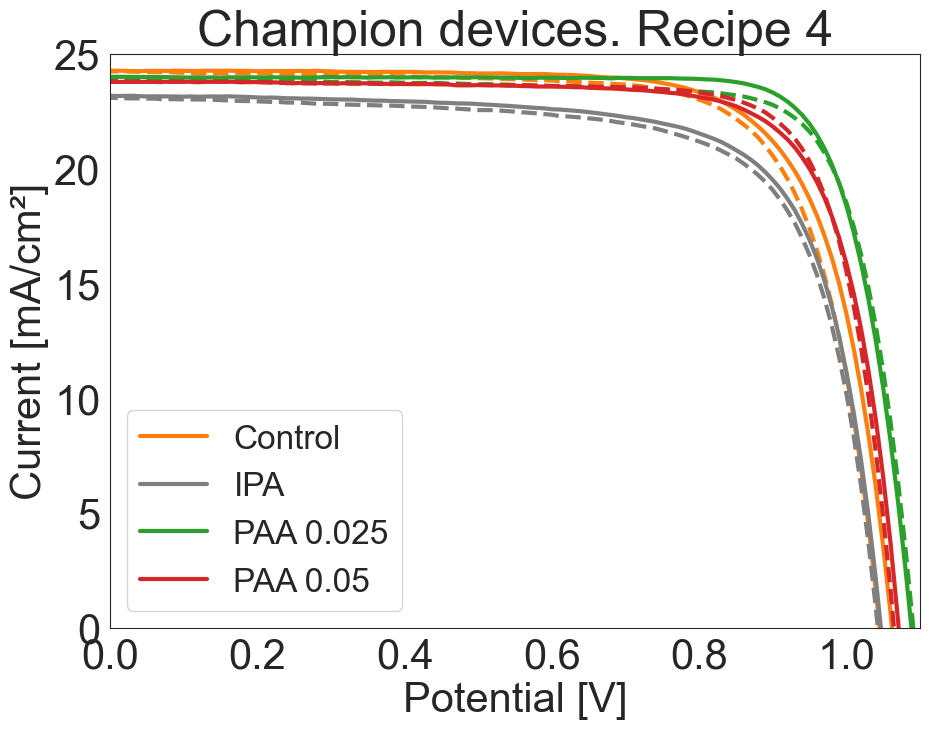

In [37]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot
l_1 = sns.lineplot(data=IV_rev[0], x="V(V)", y="J(mA/cm²)", 
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="Control",
                ax=ax
                )

l_1 = sns.lineplot(data=IV_for[0], x="V(V)", y="J(mA/cm²)", 
                color=sns.color_palette("tab10")[1],
                lw=3,
                linestyle="--",
                ax=ax
                )

l_6 = sns.lineplot(data=IV_rev[3], x="V(V)", y="J(mA/cm²)", 
                color=sns.color_palette("tab10")[7],
                lw=3,
                label="IPA",
                ax=ax
                )

l_7 = sns.lineplot(data=IV_for[3], x="V(V)", y="J(mA/cm²)", 
                color=sns.color_palette("tab10")[7],
                lw=3,
                linestyle="--",
                ax=ax
                )

l_2 = sns.lineplot(data=IV_rev[1], x="V(V)", y="J(mA/cm²)", 
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PAA 0.025",
                ax=ax
                )

l_3 = sns.lineplot(data=IV_for[1], x="V(V)", y="J(mA/cm²)", 
                color=sns.color_palette("tab10")[2],
                lw=3,
                linestyle="--",
                ax=ax
                )

l_4 = sns.lineplot(data=IV_rev[2], x="V(V)", y="J(mA/cm²)", 
                color=sns.color_palette("tab10")[3],
                lw=3,
                label="PAA 0.05",
                ax=ax
                )

l_5 = sns.lineplot(data=IV_for[2], x="V(V)", y="J(mA/cm²)", 
                color=sns.color_palette("tab10")[3],
                lw=3,
                linestyle="--",
                ax=ax
                )

ax.set_xlim([0, 1.10])
ax.set_ylim([0, 25])

ax.set_xlabel("Potential [V]")
ax.set_ylabel("Current [mA/cm²]")

ax.legend(fontsize=24)
ax.set_title("Champion devices. Recipe 4")

# ax.get_legend().set_visible(False)
# fileName = 'IC champion recepie 4 v3'
# save_figure(path_figure_folder, fileName, fig)

#### Champion devices recipi 6

In [63]:
# File paths
files = ["CC-0002_240119_1_control_recipe 6.csv", "CC-0001_240119_1_0.025%PAA_recipe 6.csv"]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "IV", "champion devices under condition 6")
path_data = [os.path.join(path_data_folder, file) for file in files]

# Read in data for forward and reversed scan in separate dataframes
IV_rev = [pd.read_csv(path, header=8, nrows =132) for path in path_data]
IV_for = [pd.read_csv(path, header=161) for path in path_data]

In [64]:
IV_rev[0]

TIME  V(V)      I(mA)  J(mA/cm²)     R(ohm)      P(mW)  Isc(mA)  \
0    0.000000  1.40  -9.749720 -168.09860 -143.59390 -13.649610      NaN   
1    0.063148  1.39 -12.949220 -223.26240 -107.34240 -17.999410      NaN   
2    0.126288  1.38 -13.025820 -224.58310 -105.94340 -17.975630      NaN   
3    0.189423  1.37 -12.652080 -218.13920 -108.28260 -17.333340      NaN   
4    0.252547  1.36 -12.120820 -208.97960 -112.20370 -16.484310      NaN   
..        ...   ...        ...        ...        ...        ...      ...   
127  8.017508  0.13   1.440326   24.83321   90.25735   0.187242      NaN   
128  8.080634  0.12   1.439841   24.82484   83.34254   0.172781      NaN   
129  8.143736  0.11   1.439223   24.81418   76.43014   0.158314      NaN   
130  8.206833  0.10   1.440436   24.83510   69.42342   0.144044      NaN   
131  8.269953  0.09   1.441390   24.85155   62.43974   0.129725      NaN   

     Jsc(mA/cm²)  Voc(V)  Pmax(mW)  Vpmax(V)  Ipmax(mA)  FF(%)  Etac(%)  
0            NaN     NaN       NaN       NaN        NaN    NaN      NaN  
1            NaN     NaN       NaN       NaN        NaN    NaN      NaN  
2            NaN     NaN       NaN       NaN        NaN    NaN      NaN  
3            NaN     NaN       NaN       NaN        NaN    NaN      NaN  
4            NaN     NaN       NaN       NaN        NaN    NaN      NaN  
..           ...     ...       ...       ...        ...    ...      ...  
127          NaN     NaN       NaN       NaN        NaN    NaN      NaN  
128          NaN     NaN       NaN       NaN        NaN    NaN      NaN  
129          NaN     NaN       NaN       NaN        NaN    NaN      NaN  
130          NaN     NaN       NaN       NaN        NaN    NaN      NaN  
131          NaN     NaN       NaN       NaN        NaN    NaN      NaN  

[132 rows x 14 columns]

In [65]:
IV_for[0]

TIME  V(V)      I(mA)  J(mA/cm²)     R(ohm)      P(mW)   Isc(mA)  \
0    0.000000 -0.10   1.450147   25.00254  -68.95851  -0.145015       NaN   
1    0.063106 -0.09   1.446252   24.93537  -62.22983  -0.130163       NaN   
2    0.126232 -0.08   1.444425   24.90388  -55.38535  -0.115554       NaN   
3    0.189341 -0.07   1.445222   24.91763  -48.43545  -0.101166       NaN   
4    0.252452 -0.06   1.444841   24.91106  -41.52705  -0.086690       NaN   
..        ...   ...        ...        ...        ...        ...       ...   
147  9.280023  1.37 -13.119560 -226.19930 -104.42430 -17.973790       NaN   
148  9.343149  1.38 -14.024850 -241.80770  -98.39679 -19.354290       NaN   
149  9.406292  1.39 -14.955060 -257.84580  -92.94515 -20.787530       NaN   
150  9.469433  1.40 -15.000360 -258.62680  -93.33112 -21.000500       NaN   
151       NaN   NaN        NaN        NaN        NaN        NaN  1.444575   

     Jsc(mA/cm²)    Voc(V)  Pmax(mW)  Vpmax(V)  Ipmax(mA)      FF(%)  \
0            NaN       NaN       NaN       NaN        NaN        NaN   
1            NaN       NaN       NaN       NaN        NaN        NaN   
2            NaN       NaN       NaN       NaN        NaN        NaN   
3            NaN       NaN       NaN       NaN        NaN        NaN   
4            NaN       NaN       NaN       NaN        NaN        NaN   
..           ...       ...       ...       ...        ...        ...   
147          NaN       NaN       NaN       NaN        NaN        NaN   
148          NaN       NaN       NaN       NaN        NaN        NaN   
149          NaN       NaN       NaN       NaN        NaN        NaN   
150          NaN       NaN       NaN       NaN        NaN        NaN   
151     24.90647  1.121941  1.217865      0.93   1.309532  75.143049   

       Etac(%)  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
..         ...  
147        NaN  
148        NaN  
149        NaN  
150        NaN  
151  20.997664  

[152 rows x 14 columns]

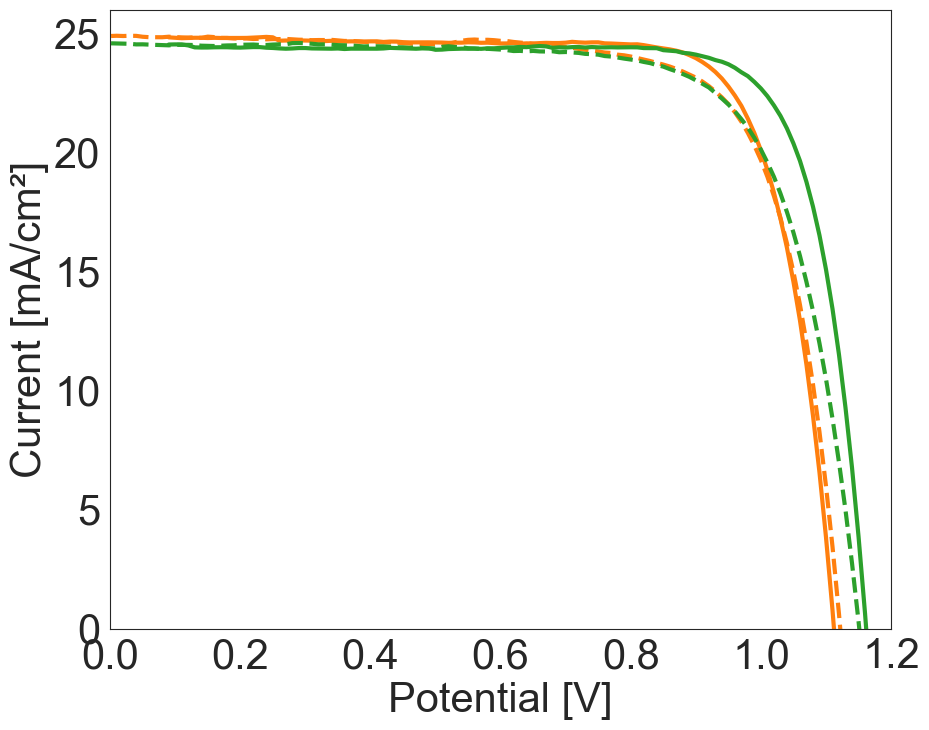

In [67]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot
l_1 = sns.lineplot(data=IV_rev[0], x="V(V)", y="J(mA/cm²)", 
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="Control",
                ax=ax
                )

l_1 = sns.lineplot(data=IV_for[0], x="V(V)", y="J(mA/cm²)", 
                color=sns.color_palette("tab10")[1],
                lw=3,
                linestyle="--",
                ax=ax
                )

l_2 = sns.lineplot(data=IV_rev[1], x="V(V)", y="J(mA/cm²)", 
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PAA 0.025",
                ax=ax
                )

l_2 = sns.lineplot(data=IV_for[1], x="V(V)", y="J(mA/cm²)", 
                color=sns.color_palette("tab10")[2],
                lw=3,
                linestyle="--",
                ax=ax
                )

ax.set_xlim([0, 1.2])
ax.set_ylim([0, 26])

ax.set_xlabel("Potential [V]")
ax.set_ylabel("Current [mA/cm²]")

ax.legend(fontsize=24)

ax.get_legend().set_visible(False)
# fileName = 'IC champion recepie 6 v2'
# save_figure(path_figure_folder, fileName, fig)

#### Stabilised Efficiency

In [38]:
# File paths
files = ["control-spo.csv", "PAA-spo.csv"]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "IV", "SPO of best devices under condition 4")
path_data = [os.path.join(path_data_folder, file) for file in files]

# Read in data for forward and reversed scan in separate dataframes
SPO = [pd.read_csv(path) for path in path_data]

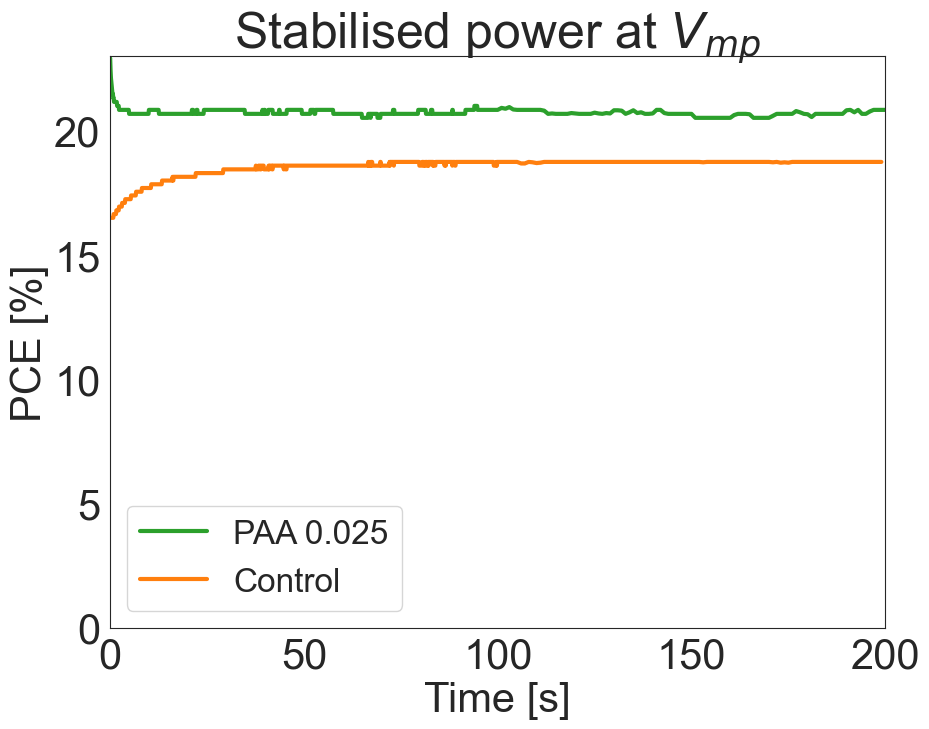

In [39]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot
sns.lineplot(data=SPO[1], x="TIME", y="pce",
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PAA 0.025",
                ax=ax
                )

sns.lineplot(data=SPO[0], x="TIME", y="pce", 
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="Control",
                ax=ax
                )

ax.set_xlim([0, 200])
ax.set_ylim([0, 23])

ax.set_xlabel("Time [s]")
ax.set_ylabel("PCE [%]")
ax.set_title("Stabilised power at $V_{mp}$")
ax.legend(fontsize=24)

# ax.get_legend().set_visible(False)
# fileName = 'SPO recepie 4 v3'
# save_figure(path_figure_folder, fileName, fig)

### EQE data

In [40]:
# File paths
files = ["control.txt", "0.025% PAA.txt"]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "EQE")
path_data = [os.path.join(path_data_folder, file) for file in files]

EQE = [pd.read_csv(path, encoding='ISO-8859-1', sep=" ") for path in path_data]

for i, x in enumerate(EQE):
    EQE[i] = EQE[i].iloc[:,[0, 2, 3, 4, 5]].copy()
    col = EQE[i].columns
    EQE[i].rename(columns={col[0]: "lambda",
                           col[1]: "s1",
                           col[2]: "s2",
                           col[3]: "QE",
                           col[4]: "s3",
                           },
                  inplace=True)

In [41]:
# Referense sol data
astm_files = 'astmg173.xlsx'
sol_path = os.path.join(os.path.abspath(os.getcwd()), "Data", "EQE", astm_files)
sol = pd.read_excel(sol_path, header = 1)
# ['Wavelength nm', 'Etr W*m-2*nm-1', 'Global tilt  W*m-2*nm-1', 'Direct+circumsolar W*m-2*nm-1'],

def QE_integration(data, sol):
    # Reads in a datafram with lambda and QE as columns
    
    QEdata = data.copy()
    # F = 96485       # Faradays constant
    # NA = 6.022E23   # Avogadros constant
    
    # Interpolate the solar spectrum to teh wavelengths to which we have QE-data
    QEdata['AM1.5'] = np.interp(QEdata['lambda'], sol['Wvlgth nm'], sol['Global tilt  W*m-2*nm-1'])
    
    QEdata['AM1.5_flux'] = QEdata['AM1.5'] * QEdata['lambda'] / 1240
    
    QEdata['EQ*AM1.5'] = QEdata['QE']*QEdata['AM1.5_flux'] /1000 # /1000 to get it in mA/cm2 instead of in A/m^2
    
    # Integrate data
    # np.trapz(data['EQ*AM1.5'], data['lambda'])
    Jsc_cumulative = integrate.cumtrapz(QEdata['EQ*AM1.5'], QEdata['lambda'], initial = 0)
    
    return Jsc_cumulative

In [42]:
# Get integrated EQE data
EQE[0]["Jsc"] = QE_integration(EQE[0], sol) * 100
EQE[1]["Jsc"] = QE_integration(EQE[1], sol) * 100

print(EQE[0]["Jsc"].tail(1).values)
print(EQE[1]["Jsc"].tail(1).values)

[22.93385018]
[22.5574762]


C:\Users\jesja78\AppData\Local\Temp\ipykernel_26436\1050214718.py:23: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  Jsc_cumulative = integrate.cumtrapz(QEdata['EQ*AM1.5'], QEdata['lambda'], initial = 0)
C:\Users\jesja78\AppData\Local\Temp\ipykernel_26436\1050214718.py:23: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  Jsc_cumulative = integrate.cumtrapz(QEdata['EQ*AM1.5'], QEdata['lambda'], initial = 0)


In [43]:
# Band gap from the inflection point
def get_Eg_inflection(userdata):
    "Estimate Eg by the inflection point"
    
    data = userdata.copy()
    
    # data = pd.DataFrame()
    # data['lambda'] = np.linespace()
    
    # differentiate data numerically
    data['dydx'] = np.gradient(data['QE'], data['lambda'])
    
    # The wavelength at the min of the first derivate (may not give right answer every time)
    Eg_estimate = 1240/data.at[data['dydx'].idxmin(), 'lambda']
    
    return Eg_estimate

Eg1 = get_Eg_inflection(EQE[0])
Eg2 = get_Eg_inflection(EQE[1])

print(Eg1)
print(Eg2)

1.55
1.559748427672956


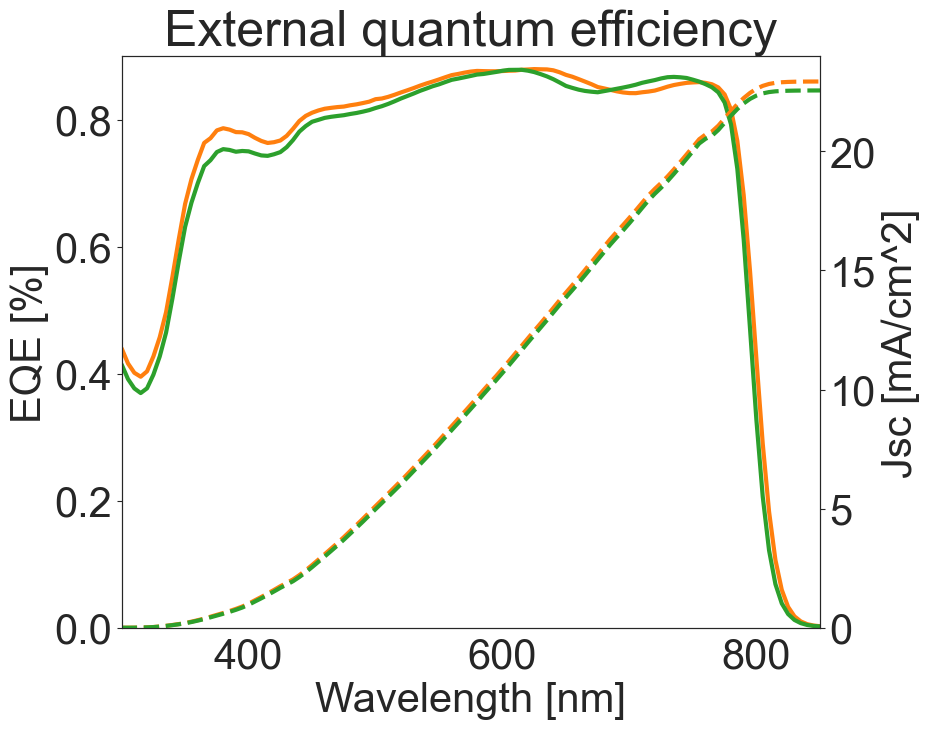

In [44]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot
l_1 = sns.lineplot(data=EQE[0], x="lambda", y="QE", 
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="Control",
                ax=ax
                )

l_1 = sns.lineplot(data=EQE[1], x="lambda", y="QE", 
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PA 0.025",
                ax=ax
                )

ax2 = ax.twinx()

sns.lineplot(data=EQE[0], x = 'lambda', y = 'Jsc', 
                   color=sns.color_palette("tab10")[1],
                   linestyle="--",
                   lw=3,
                   ax = ax2)

sns.lineplot(data=EQE[1], x = 'lambda', y = 'Jsc', 
                   color=sns.color_palette("tab10")[2],
                   linestyle="--",
                   lw=3,
                   ax = ax2)

ax2.set_ylim([0, 24])
ax2.set_ylabel('Jsc [mA/cm^2]')
ax2.tick_params(axis='y')


ax.set_xlim([300, 850])
ax.set_ylim([0, 0.9])

ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("EQE [%]")
ax.set_title("External quantum efficiency")

ax.legend(fontsize=24)

ax.get_legend().set_visible(False)
# fileName = 'EQE v2'
# save_figure(path_figure_folder, fileName, fig)

### Stability

In [45]:
# File paths
files = ["Control-1.csv","PAA-1.csv","Control-2.csv","PAA-2.csv"]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "MPPT")
path_data = [os.path.join(path_data_folder, file) for file in files]

# Read in data for forward and reversed scan in separate dataframes
MPPT = [pd.read_csv(path) for path in path_data]

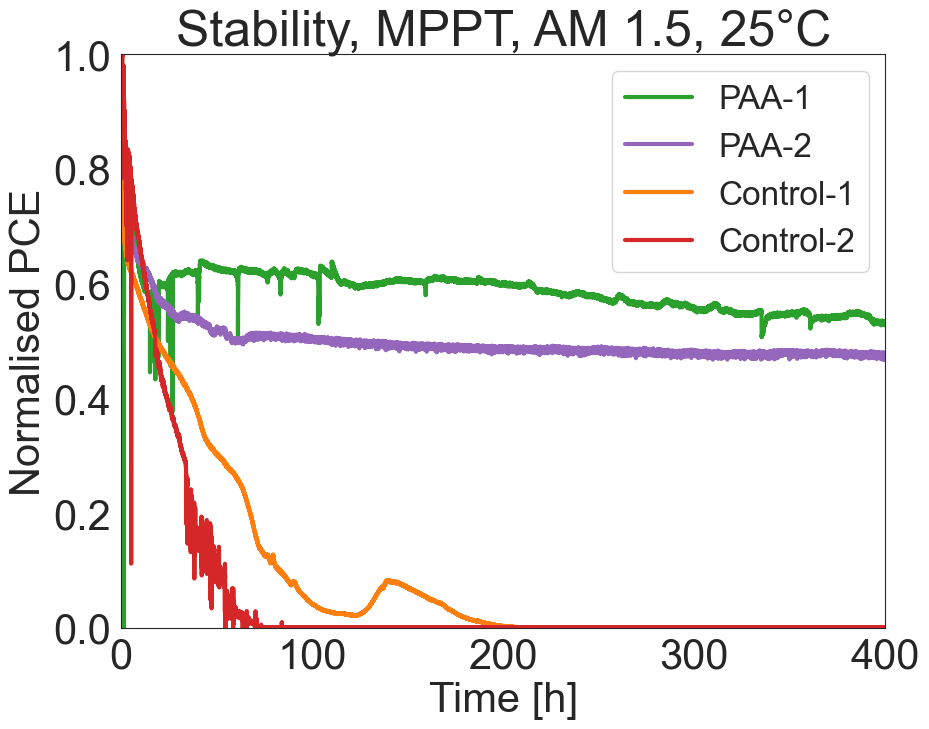

In [46]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot
sns.lineplot(data=MPPT[1], x="Time(h)", y="Normalized PCE",
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PAA-1",
                ax=ax
                )

sns.lineplot(data=MPPT[3], x="Time(h)", y="Normalized PCE",
                color=sns.color_palette("tab10")[4],
                lw=3,
                label="PAA-2",
                ax=ax
                )

sns.lineplot(data=MPPT[0], x="Time(h)", y="Normalized PCE", 
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="Control-1",
                ax=ax
                )

sns.lineplot(data=MPPT[2], x="Time(h)", y="Normalized PCE",
                color=sns.color_palette("tab10")[3],
                lw=3,
                label="Control-2",
                ax=ax
                )

ax.set_xlim([0, 400])
ax.set_ylim([0, 1])

ax.set_xlabel("Time [h]")
ax.set_ylabel("Normalised PCE")
ax.set_title("Stability, MPPT, AM 1.5, 25°C")

ax.legend(fontsize=24)

# fileName = 'MPPT recepie 4 v3'
# save_figure(path_figure_folder, fileName, fig)

### Device data

In [47]:
# File paths
file = "Device data perovsktie database protocol v3.xlsx"
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "Device data")
path_data =os.path.join(path_data_folder, file) 

device_data = pd.read_excel(path_data, sheet_name="Master", index_col=0, header=None).T

device_data["Recepie"] = pd.to_numeric(device_data["Recepie"]) 
device_data["PAA_treatment"] = device_data["PAA_treatment"].astype("bool") 

c:\Users\jesja78\.conda\envs\chatgpt_manuscript\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [48]:
device_data.head(10)

0  Ref. ID temp (Integer starting from 1 and counting upwards)  \
1                                                   1            
2                                                   2            
3                                                   3            
4                                                   4            
5                                                   5            
6                                                   6            
7                                                   7            
8                                                   8            
9                                                   9            
10                                                 10            

0  Ref. Name of person entering the data  \
1                              Chen Chen   
2                              Chen Chen   
3                              Chen Chen   
4                              Chen Chen   
5                              Chen Chen   
6                              Chen Chen   
7                              Chen Chen   
8                              Chen Chen   
9                              Chen Chen   
10                             Chen Chen   

0  Ref. Data entered by author [TRUE/FALSE] Ref. DOI number  Ref. Lead author  \
1                                         1             NaN  Chen Chen et al.   
2                                      True             NaN  Chen Chen et al.   
3                                      True             NaN  Chen Chen et al.   
4                                      True             NaN  Chen Chen et al.   
5                                      True             NaN  Chen Chen et al.   
6                                      True             NaN  Chen Chen et al.   
7                                      True             NaN  Chen Chen et al.   
8                                      True             NaN  Chen Chen et al.   
9                                      True             NaN  Chen Chen et al.   
10                                     True             NaN  Chen Chen et al.   

0  Ref. Publication date [year:mm:dd]  \
1                                 NaN   
2                                 NaN   
3                                 NaN   
4                                 NaN   
5                                 NaN   
6                                 NaN   
7                                 NaN   
8                                 NaN   
9                                 NaN   
10                                NaN   

0  Ref. Free text comment (max 280 characters)  Recepie Batch  PAA_treatment  \
1                                            1        1   NaN           True   
2                                            2        1   NaN           True   
3                                            3        1   NaN           True   
4                                            4        1   NaN           True   
5                                            5        1   NaN           True   
6                                            6        1   NaN           True   
7                                            7        1   NaN           True   
8                                            8        1   NaN           True   
9                                            9        1   NaN           True   
10                                          10        1   NaN           True   

0   ... Outdoor. PCE. Tse80 [h] Outdoor. PCE. After 1000 h [% of initial PCE]  \
1   ...                     NaN                                           NaN   
2   ...                     NaN                                           NaN   
3   ...                     NaN                                           NaN   
4   ...                     NaN                                           NaN   
5   ...                     NaN                                           NaN   
6   ...                     NaN                                           NaN

#### Swarm plots

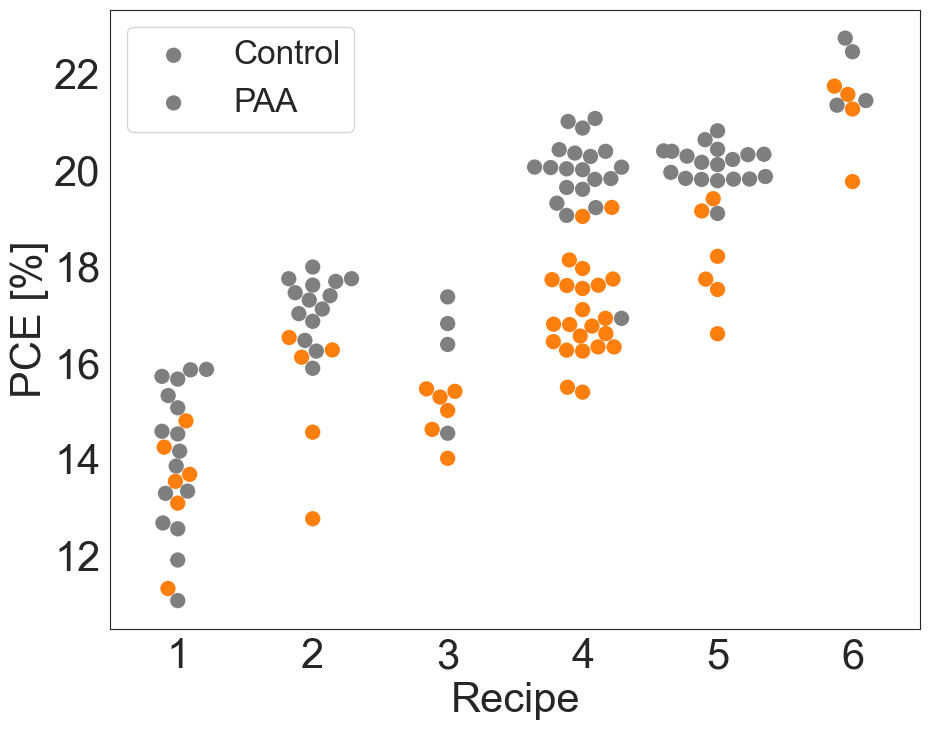

In [49]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Compare results with and without PAA
sns.swarmplot(data=device_data, y="JV. Reverse scan. PCE [%] ", x="Recepie", 
              hue="PAA_treatment",
              size=11,
              palette=[sns.color_palette("tab10")[1], sns.color_palette("tab10")[7]],
              )

ax.set_xlabel("Recipe")
ax.set_ylabel("PCE [%]")
plt.legend(fontsize=24, labels=["Control", "PAA"])

# ax.set_title("PCE vs PAA treatment and recipe")

# fileName = 'Device performance swarm PCE 1 v2'
# save_figure(path_figure_folder, fileName, fig)

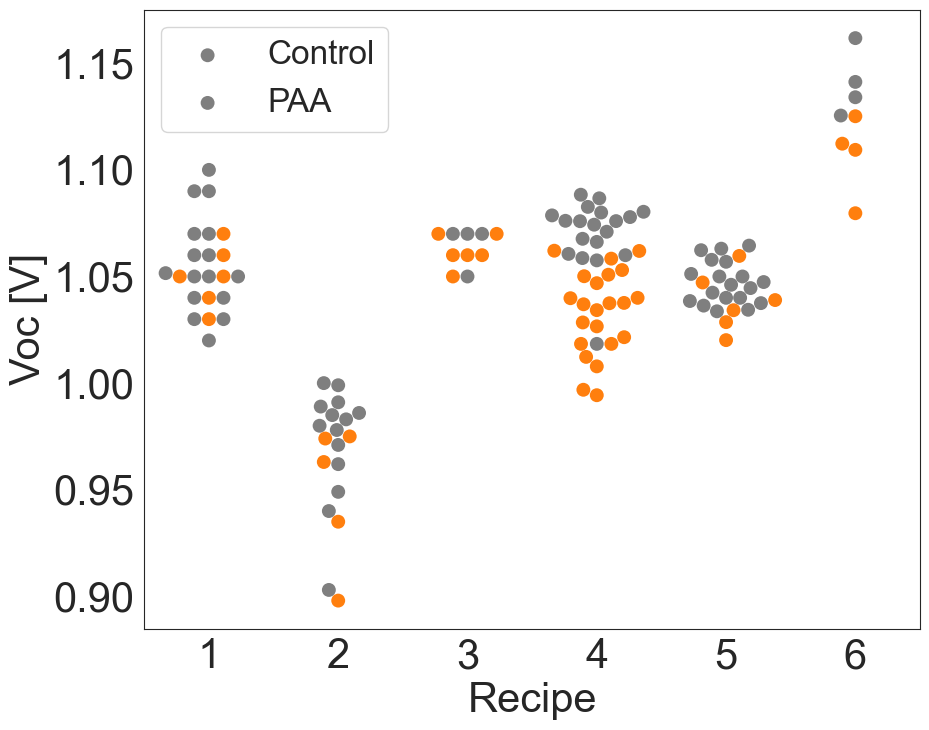

In [13]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Compare results with and without PAA
sns.swarmplot(data=device_data, y="JV. Reverse scan. Voc [V]", x="Recepie", 
              hue="PAA_treatment",
              size=10,
              palette=[sns.color_palette("tab10")[1], sns.color_palette("tab10")[7]],
              )

ax.set_xlabel("Recipe")
ax.set_ylabel("Voc [V]")
plt.legend(fontsize=24, labels=["Control", "PAA"])

# fileName = 'Device performance swarm Voc 1 v1'
# save_figure(path_figure_folder, fileName, fig)

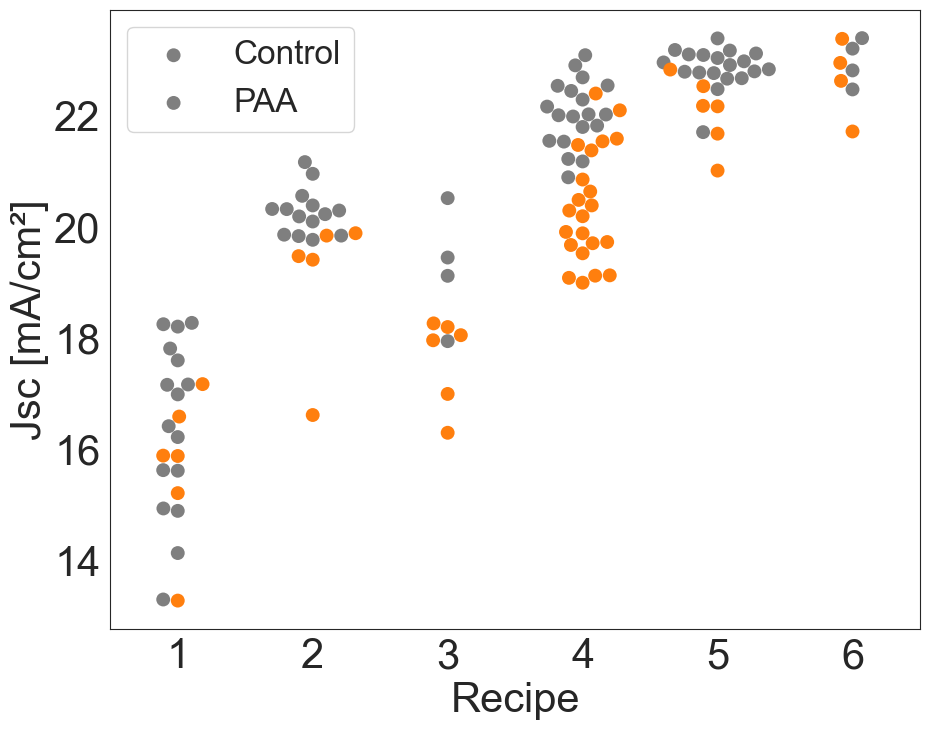

In [16]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Compare results with and without PAA
sns.swarmplot(data=device_data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="Recepie", 
              hue="PAA_treatment",
              size=10,
              palette=[sns.color_palette("tab10")[1], sns.color_palette("tab10")[7]],
              )

ax.set_xlabel("Recipe")
ax.set_ylabel("Jsc [mA/cm²]")
plt.legend(fontsize=24, labels=["Control", "PAA"])

# fileName = 'Device performance swarm Jsc 1 v1'
# save_figure(path_figure_folder, fileName, fig)

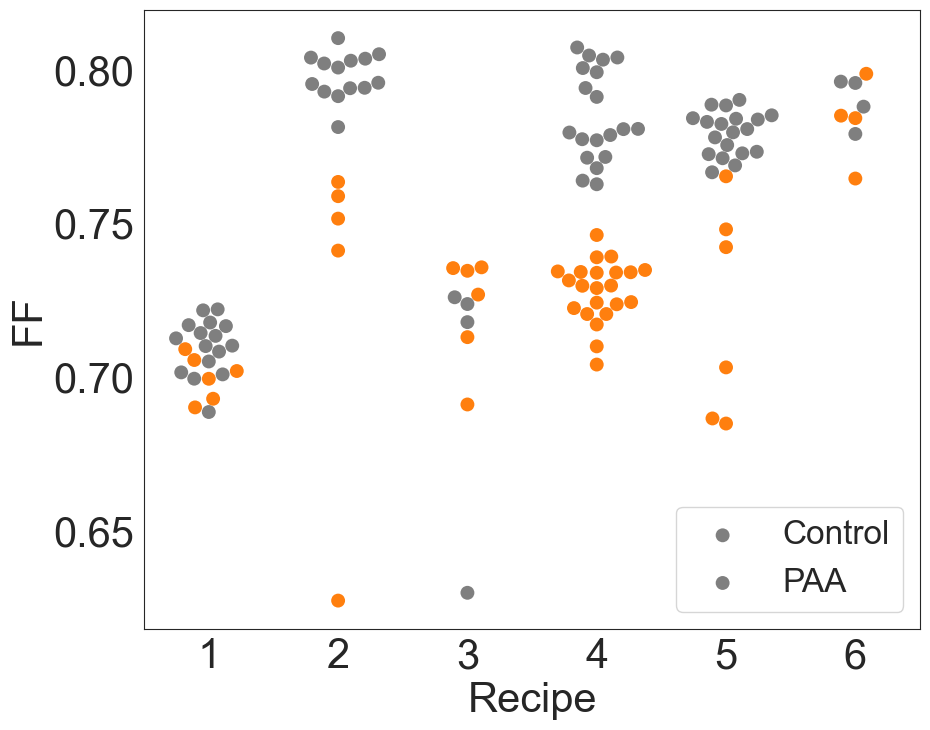

In [19]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Compare results with and without PAA
sns.swarmplot(data=device_data, y="JV. Reverse scan. FF [number between 0 and 1]", x="Recepie", 
              hue="PAA_treatment",
              size=10,
              palette=[sns.color_palette("tab10")[1], sns.color_palette("tab10")[7]],
              )

ax.set_xlabel("Recipe")
ax.set_ylabel("FF")
plt.legend(fontsize=24, labels=["Control", "PAA"])

fileName = 'Device performance swarm FF 1 v1'
save_figure(path_figure_folder, fileName, fig)

#### Boxplots

C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\4112895305.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\4112895305.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\4112895305.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipyke

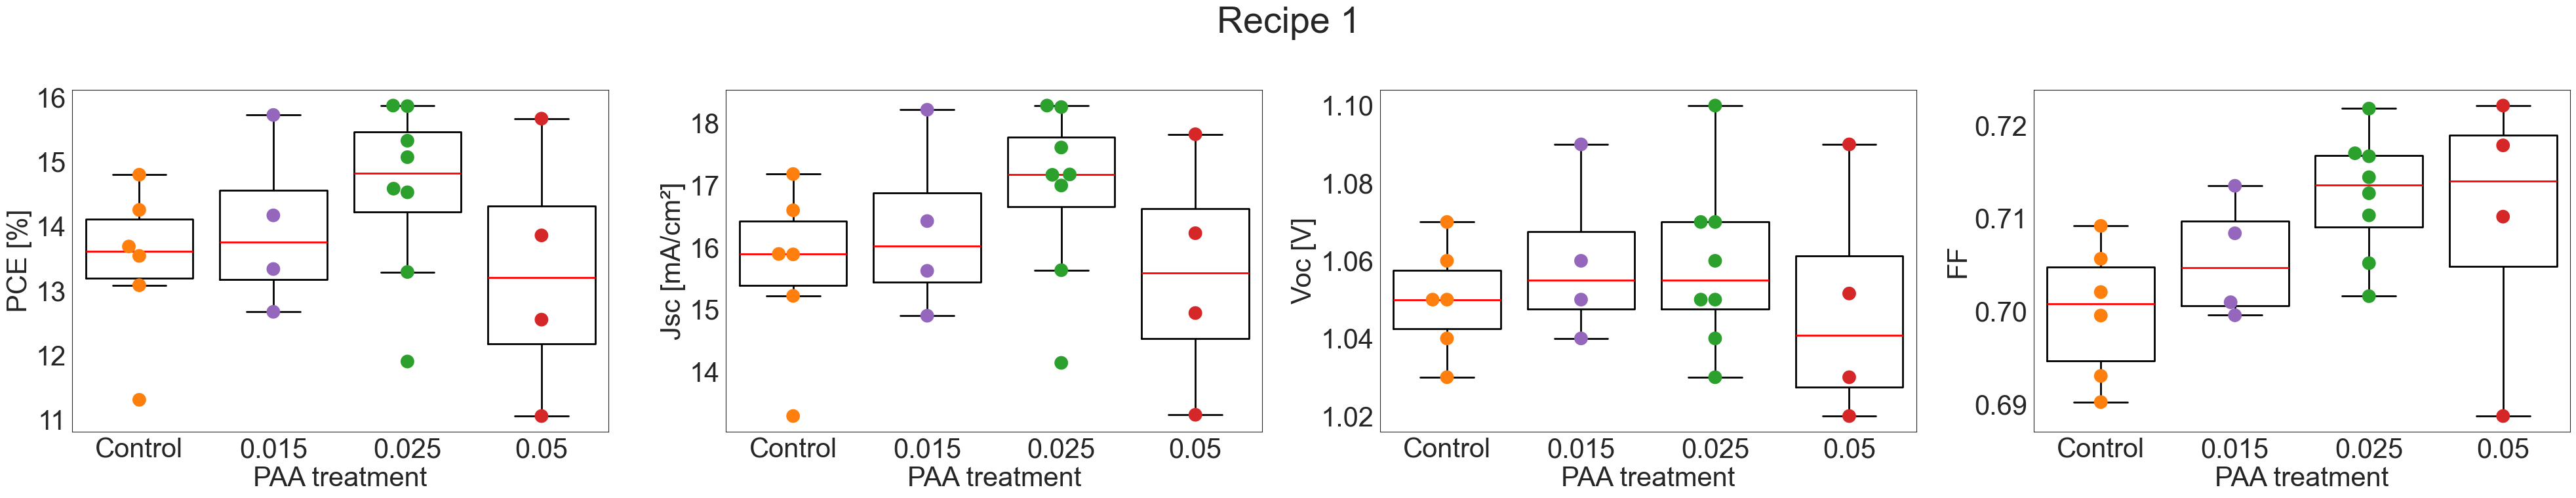

In [57]:
data = device_data[device_data["Recepie"].isin([1])]
# data[["JV. Reverse scan. PCE [%] ", "Recepie", "PAA_treatment"]]

# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
# fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)
fig, axs = plt.subplots(1, 4, figsize=(40, 8))

col = sns.color_palette("tab10")

sns.boxplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.015", "0.025", "0.05"],
            ax=axs[0]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",
              order=["Control", "0.015", "0.025", "0.05"],
              palette=[col[1], col[4], col[2], col[3] ],
              size=15,
              ax=axs[0]
              )

axs[0].set_xlabel("PAA treatment")
axs[0].set_ylabel("PCE [%]")

sns.boxplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.015", "0.025", "0.05"],
            ax=axs[1]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA",
              order=["Control", "0.015", "0.025", "0.05"],
              palette=[col[1], col[4], col[2], col[3] ],
              size=15,
              ax=axs[1]
              )

axs[1].set_xlabel("PAA treatment")
axs[1].set_ylabel("Jsc [mA/cm²]")


sns.boxplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.015", "0.025", "0.05"],
            ax=axs[2]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",
              order=["Control", "0.015", "0.025", "0.05"],
              palette=[col[1], col[4], col[2], col[3] ],
              size=15,
              ax=axs[2]
              )

axs[2].set_xlabel("PAA treatment")
axs[2].set_ylabel("Voc [V]")


sns.boxplot(data=data, y="JV. Reverse scan. FF [number between 0 and 1]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.015", "0.025", "0.05"],
            ax=axs[3]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. FF [number between 0 and 1]", x="PAA",
              order=["Control", "0.015", "0.025", "0.05"],
              palette=[col[1], col[4], col[2], col[3] ],
              size=15,
              ax=axs[3]
              )

axs[3].set_xlabel("PAA treatment")
axs[3].set_ylabel("FF")

fig.suptitle("Recipe 1", fontsize=40)

fig.tight_layout()

# fileName = 'Boxplots recipe 1 v1'
# save_figure(path_figure_folder, fileName, fig)

C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\4103873792.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\4103873792.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\4103873792.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipyke

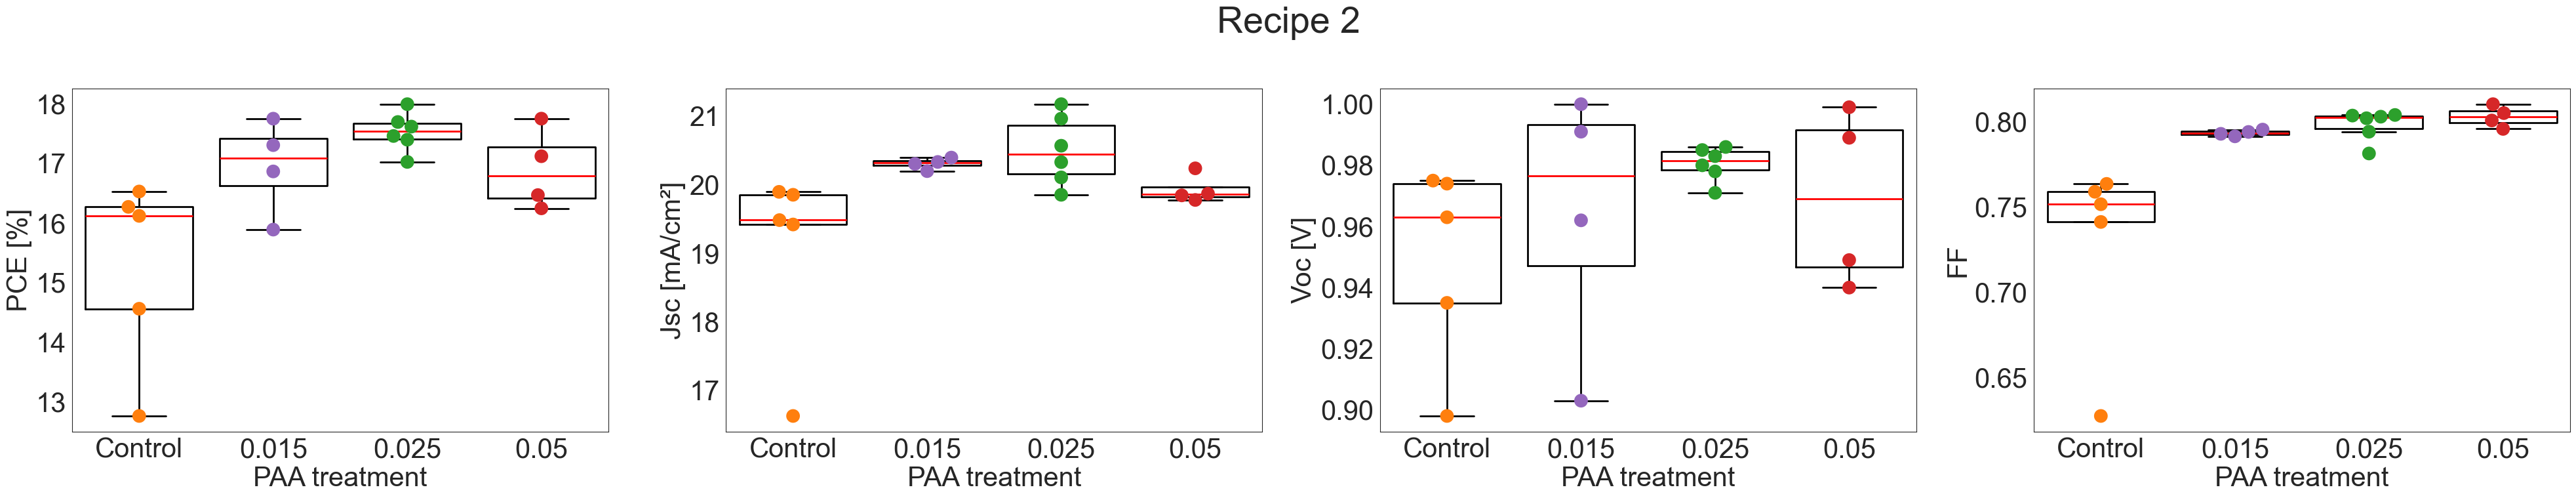

In [59]:
data = device_data[device_data["Recepie"].isin([2])]
# data[["JV. Reverse scan. PCE [%] ", "Recepie", "PAA_treatment"]]

# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
# fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)
fig, axs = plt.subplots(1, 4, figsize=(40, 8))

col = sns.color_palette("tab10")

sns.boxplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.015", "0.025", "0.05"],
            ax=axs[0]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",
              order=["Control", "0.015", "0.025", "0.05"],
              palette=[col[1], col[4], col[2], col[3] ],
              size=15,
              ax=axs[0]
              )

axs[0].set_xlabel("PAA treatment")
axs[0].set_ylabel("PCE [%]")

sns.boxplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.015", "0.025", "0.05"],
            ax=axs[1]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA",
              order=["Control", "0.015", "0.025", "0.05"],
              palette=[col[1], col[4], col[2], col[3] ],
              size=15,
              ax=axs[1]
              )

axs[1].set_xlabel("PAA treatment")
axs[1].set_ylabel("Jsc [mA/cm²]")


sns.boxplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.015", "0.025", "0.05"],
            ax=axs[2]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",
              order=["Control", "0.015", "0.025", "0.05"],
              palette=[col[1], col[4], col[2], col[3] ],
              size=15,
              ax=axs[2]
              )

axs[2].set_xlabel("PAA treatment")
axs[2].set_ylabel("Voc [V]")


sns.boxplot(data=data, y="JV. Reverse scan. FF [number between 0 and 1]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.015", "0.025", "0.05"],
            ax=axs[3]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. FF [number between 0 and 1]", x="PAA",
              order=["Control", "0.015", "0.025", "0.05"],
              palette=[col[1], col[4], col[2], col[3] ],
              size=15,
              ax=axs[3]
              )

axs[3].set_xlabel("PAA treatment")
axs[3].set_ylabel("FF")

fig.suptitle("Recipe 2", fontsize=40)

fig.tight_layout()

fileName = 'Boxplots recipe 2 v1'
save_figure(path_figure_folder, fileName, fig)

C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\2731964508.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\2731964508.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\2731964508.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipyke

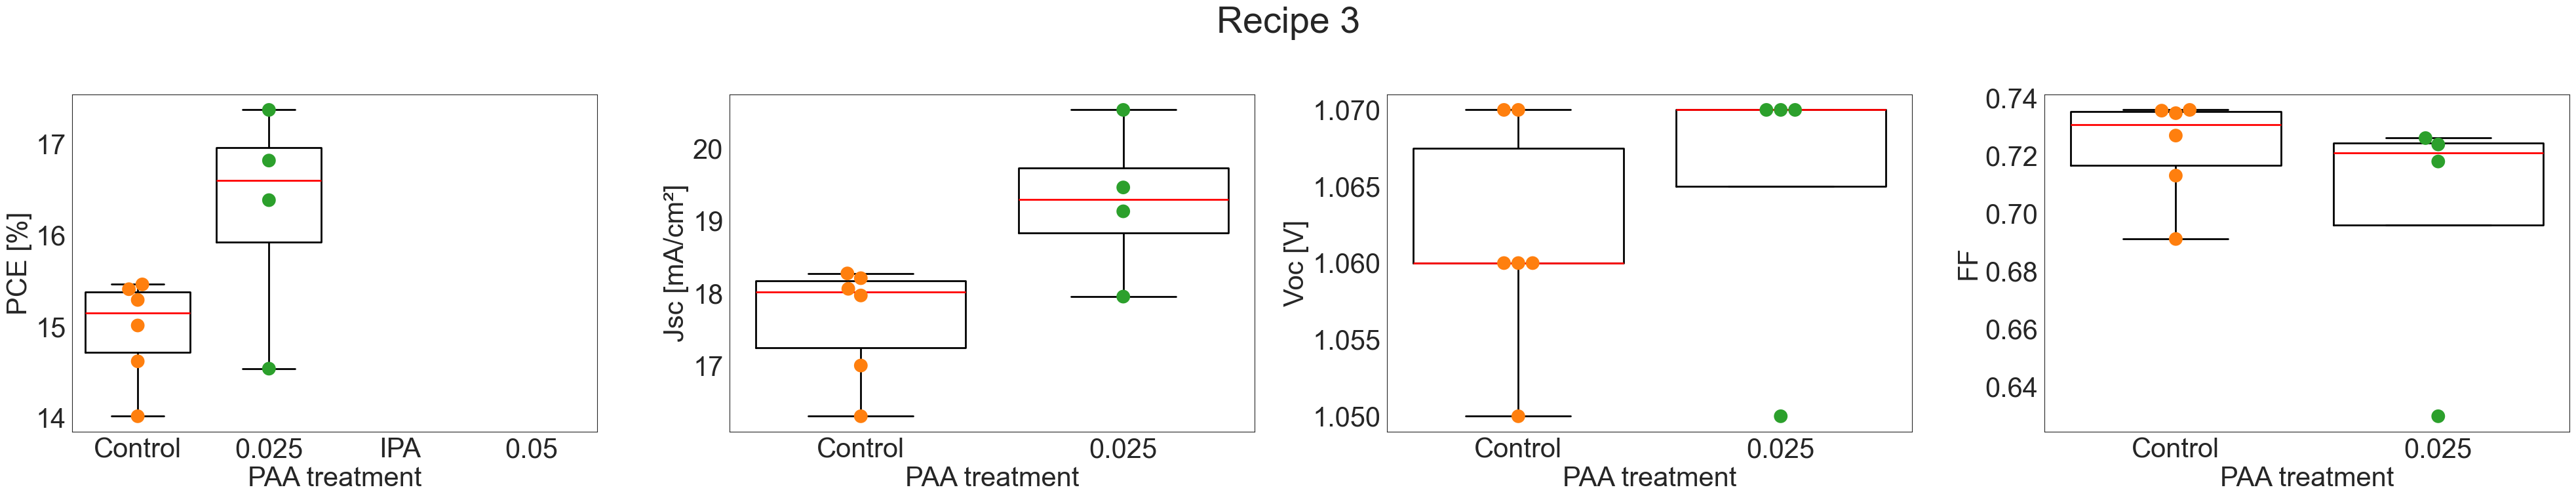

In [65]:
data = device_data[device_data["Recepie"].isin([3])]
# data[["JV. Reverse scan. PCE [%] ", "Recepie", "PAA_treatment"]]

# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
# fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)
fig, axs = plt.subplots(1, 4, figsize=(40, 8))

col = sns.color_palette("tab10")

sns.boxplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.025"],
            ax=axs[0]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",
              order=["Control", "IPA", "0.025", "0.05"],
              palette=[col[1], col[5], col[2], col[3] ],
              size=15,
              ax=axs[0]
              )

axs[0].set_xlabel("PAA treatment")
axs[0].set_ylabel("PCE [%]")

sns.boxplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.025"],
            ax=axs[1]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA",
              order=["Control", "0.025"],
              palette=[col[1], col[2]],
              size=15,
              ax=axs[1]
              )

axs[1].set_xlabel("PAA treatment")
axs[1].set_ylabel("Jsc [mA/cm²]")


sns.boxplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.025"],
            ax=axs[2]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",
              order=["Control", "0.025"],
              palette=[col[1], col[2]],
              size=15,
              ax=axs[2]
              )

axs[2].set_xlabel("PAA treatment")
axs[2].set_ylabel("Voc [V]")


sns.boxplot(data=data, y="JV. Reverse scan. FF [number between 0 and 1]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.025"],
            ax=axs[3]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. FF [number between 0 and 1]", x="PAA",
              order=["Control", "0.025"],
              palette=[col[1], col[2]],
              size=15,
              ax=axs[3]
              )

axs[3].set_xlabel("PAA treatment")
axs[3].set_ylabel("FF")

fig.suptitle("Recipe 3", fontsize=40)

fig.tight_layout()

# fileName = 'Boxplots recipe 3 v1'
# save_figure(path_figure_folder, fileName, fig)

C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\209183483.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\209183483.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\209183483.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipykerne

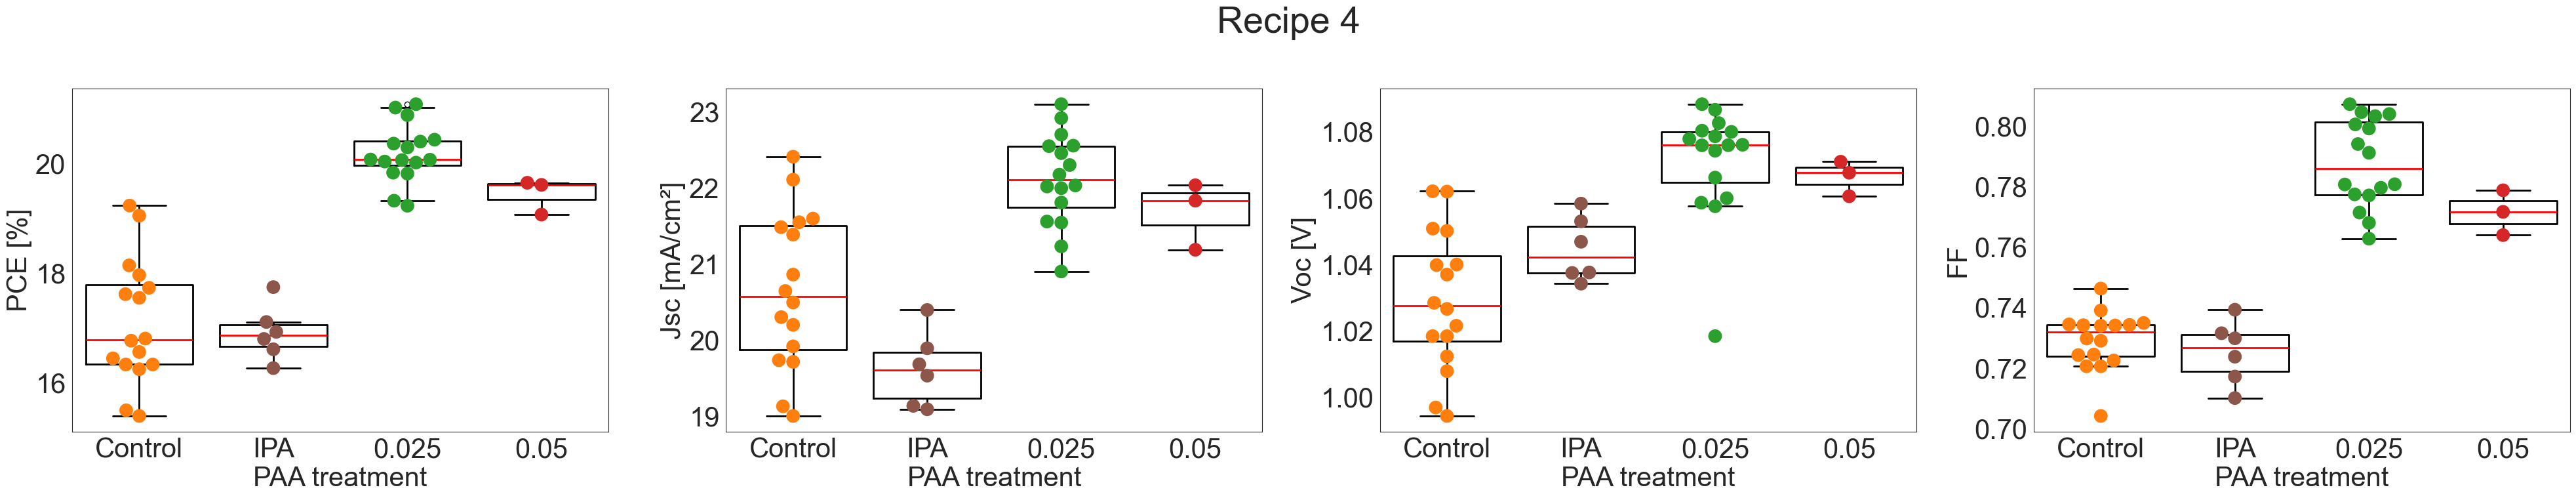

In [70]:
data = device_data[device_data["Recepie"].isin([4])]
# data[["JV. Reverse scan. PCE [%] ", "Recepie", "PAA_treatment"]]

# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
# fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)
fig, axs = plt.subplots(1, 4, figsize=(40, 8))

col = sns.color_palette("tab10")

sns.boxplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "IPA", "0.025", "0.05"],
            ax=axs[0]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",
              order=["Control", "IPA", "0.025", "0.05"],
              palette=[col[1], col[5], col[2], col[3] ],
              size=15,
              ax=axs[0]
              )

axs[0].set_xlabel("PAA treatment")
axs[0].set_ylabel("PCE [%]")

sns.boxplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "IPA", "0.025", "0.05"],
            ax=axs[1]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA",
              order=["Control", "IPA", "0.025", "0.05"],
              palette=[col[1], col[5], col[2], col[3] ],
              size=15,
              ax=axs[1]
              )

axs[1].set_xlabel("PAA treatment")
axs[1].set_ylabel("Jsc [mA/cm²]")


sns.boxplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "IPA", "0.025", "0.05"],
            ax=axs[2]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",
              order=["Control", "IPA", "0.025", "0.05"],
              palette=[col[1], col[5], col[2], col[3] ],
              size=15,
              ax=axs[2]
              )

axs[2].set_xlabel("PAA treatment")
axs[2].set_ylabel("Voc [V]")


sns.boxplot(data=data, y="JV. Reverse scan. FF [number between 0 and 1]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "IPA", "0.025", "0.05"],
            ax=axs[3]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. FF [number between 0 and 1]", x="PAA",
              order=["Control", "IPA", "0.025", "0.05"],
              palette=[col[1], col[5], col[2], col[3] ],
              size=15,
              ax=axs[3]
              )

axs[3].set_xlabel("PAA treatment")
axs[3].set_ylabel("FF")

fig.suptitle("Recipe 4", fontsize=40)

fig.tight_layout()

# fileName = 'Boxplots recipe 4 v1'
# save_figure(path_figure_folder, fileName, fig)

C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\1309368759.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\1309368759.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\1309368759.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipyke

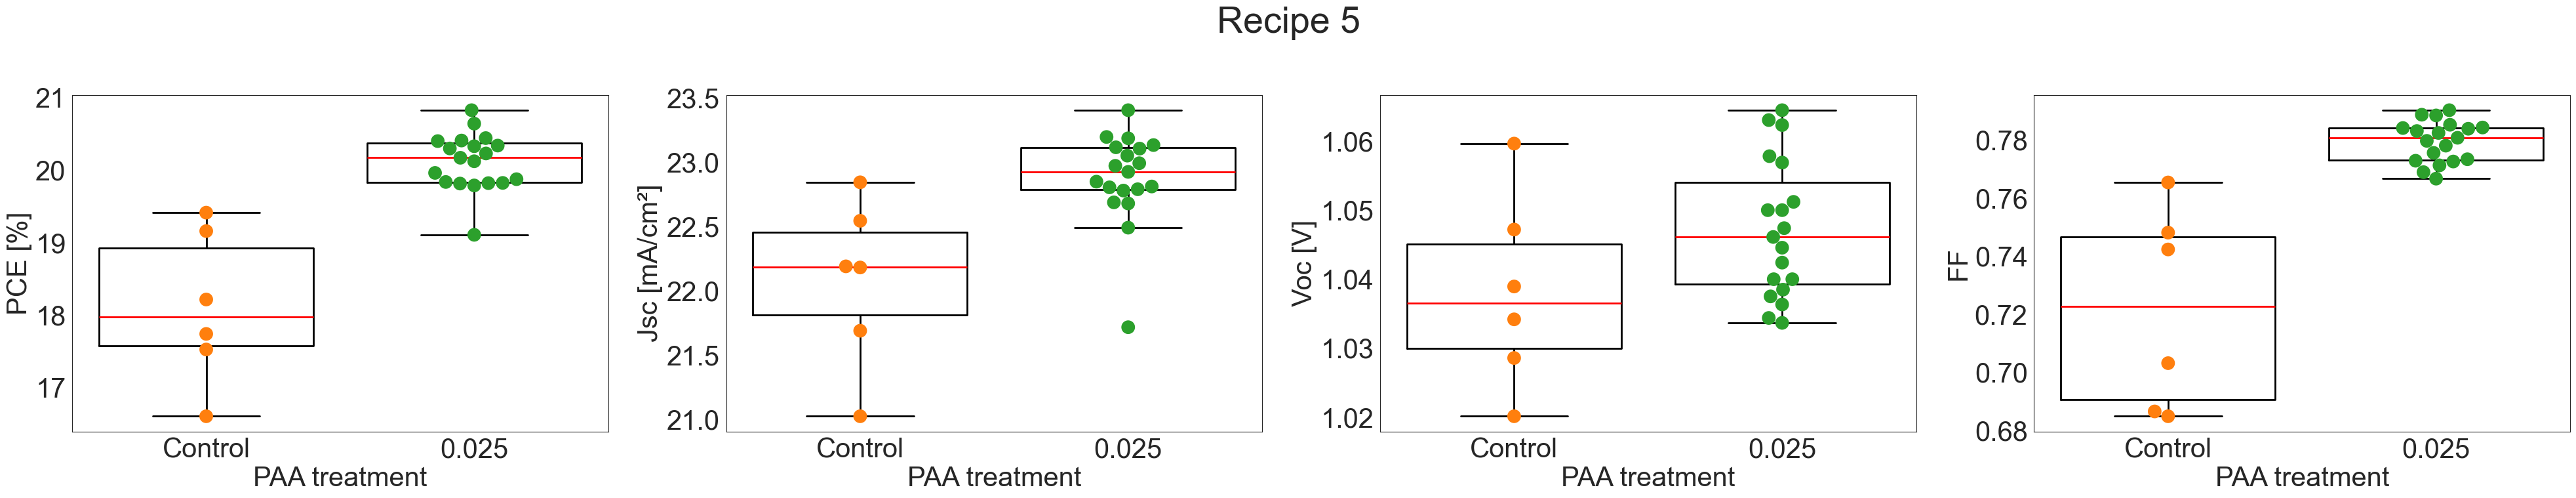

In [72]:
data = device_data[device_data["Recepie"].isin([5])]
# data[["JV. Reverse scan. PCE [%] ", "Recepie", "PAA_treatment"]]

# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
# fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)
fig, axs = plt.subplots(1, 4, figsize=(40, 8))

col = sns.color_palette("tab10")

sns.boxplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.025"],
            ax=axs[0]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",
              order=["Control", "0.025"],
              palette=[col[1], col[2]],
              size=15,
              ax=axs[0]
              )

axs[0].set_xlabel("PAA treatment")
axs[0].set_ylabel("PCE [%]")

sns.boxplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.025"],
            ax=axs[1]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA",
              order=["Control", "0.025"],
              palette=[col[1], col[2]],
              size=15,
              ax=axs[1]
              )

axs[1].set_xlabel("PAA treatment")
axs[1].set_ylabel("Jsc [mA/cm²]")


sns.boxplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.025"],
            ax=axs[2]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",
              order=["Control", "0.025"],
              palette=[col[1], col[2]],
              size=15,
              ax=axs[2]
              )

axs[2].set_xlabel("PAA treatment")
axs[2].set_ylabel("Voc [V]")


sns.boxplot(data=data, y="JV. Reverse scan. FF [number between 0 and 1]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.025"],
            ax=axs[3]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. FF [number between 0 and 1]", x="PAA",
              order=["Control", "0.025"],
              palette=[col[1], col[2]],
              size=15,
              ax=axs[3]
              )

axs[3].set_xlabel("PAA treatment")
axs[3].set_ylabel("FF")

fig.suptitle("Recipe 5", fontsize=40)

fig.tight_layout()

# fileName = 'Boxplots recipe 5 v1'
# save_figure(path_figure_folder, fileName, fig)

C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\4223854990.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\4223854990.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\4223854990.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",
C:\Users\jespe\AppData\Local\Temp\ipyke

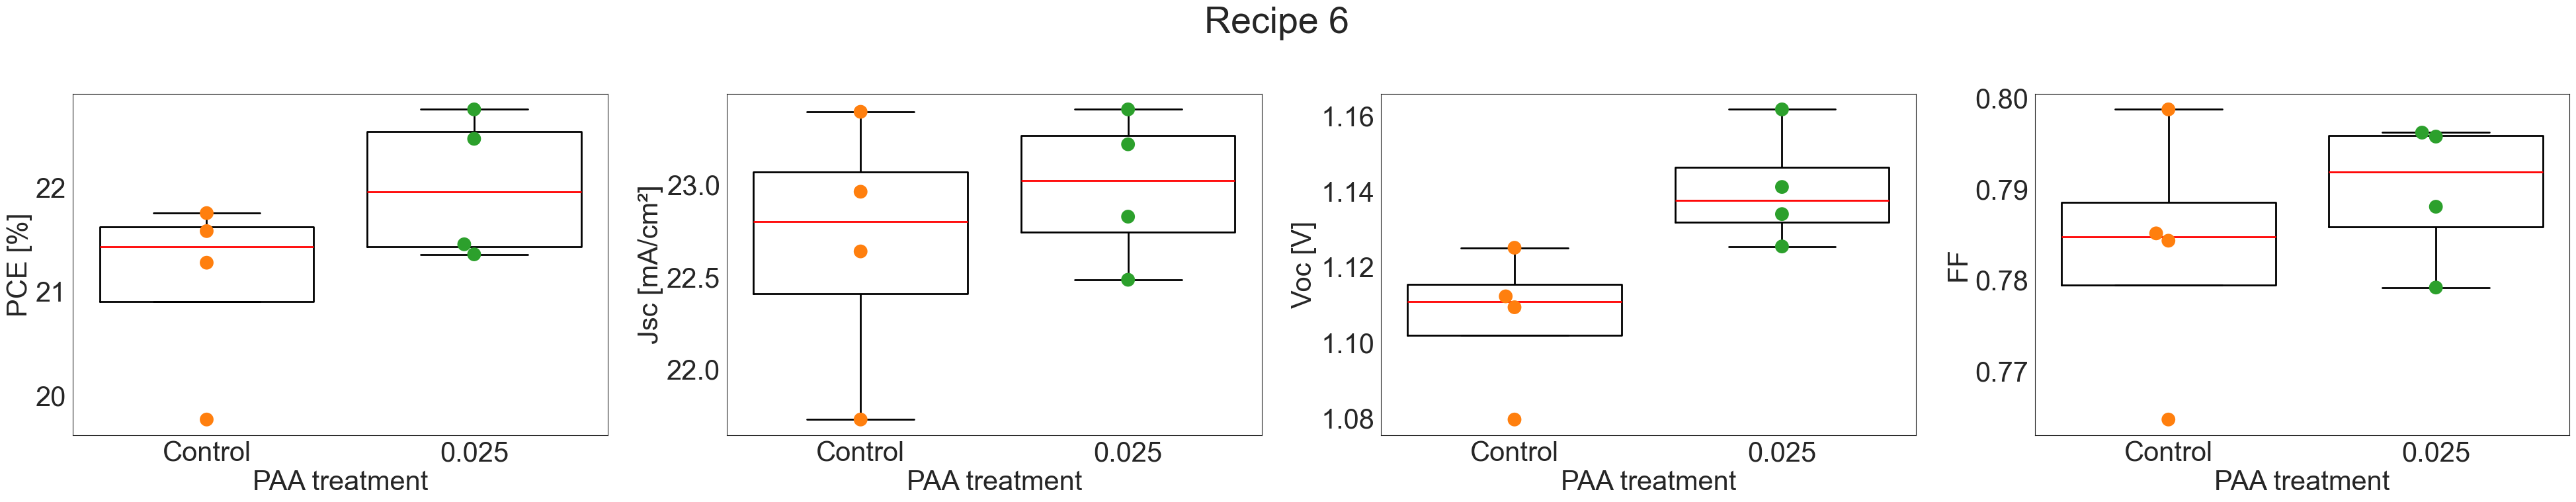

In [74]:
data = device_data[device_data["Recepie"].isin([6])]
# data[["JV. Reverse scan. PCE [%] ", "Recepie", "PAA_treatment"]]

# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
# fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)
fig, axs = plt.subplots(1, 4, figsize=(40, 8))

col = sns.color_palette("tab10")

sns.boxplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.025"],
            ax=axs[0]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",
              order=["Control", "0.025"],
              palette=[col[1], col[2]],
              size=15,
              ax=axs[0]
              )

axs[0].set_xlabel("PAA treatment")
axs[0].set_ylabel("PCE [%]")

sns.boxplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.025"],
            ax=axs[1]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. Jmp [mA/cm^2]", x="PAA",
              order=["Control", "0.025"],
              palette=[col[1], col[2]],
              size=15,
              ax=axs[1]
              )

axs[1].set_xlabel("PAA treatment")
axs[1].set_ylabel("Jsc [mA/cm²]")


sns.boxplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.025"],
            ax=axs[2]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",
              order=["Control", "0.025"],
              palette=[col[1], col[2]],
              size=15,
              ax=axs[2]
              )

axs[2].set_xlabel("PAA treatment")
axs[2].set_ylabel("Voc [V]")


sns.boxplot(data=data, y="JV. Reverse scan. FF [number between 0 and 1]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.025"],
            ax=axs[3]
              )

sns.swarmplot(data=data, y="JV. Reverse scan. FF [number between 0 and 1]", x="PAA",
              order=["Control", "0.025"],
              palette=[col[1], col[2]],
              size=15,
              ax=axs[3]
              )

axs[3].set_xlabel("PAA treatment")
axs[3].set_ylabel("FF")

fig.suptitle("Recipe 6", fontsize=40)

fig.tight_layout()

# fileName = 'Boxplots recipe 6 v1'
# save_figure(path_figure_folder, fileName, fig)

#### Individual figures

C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\2218190021.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",


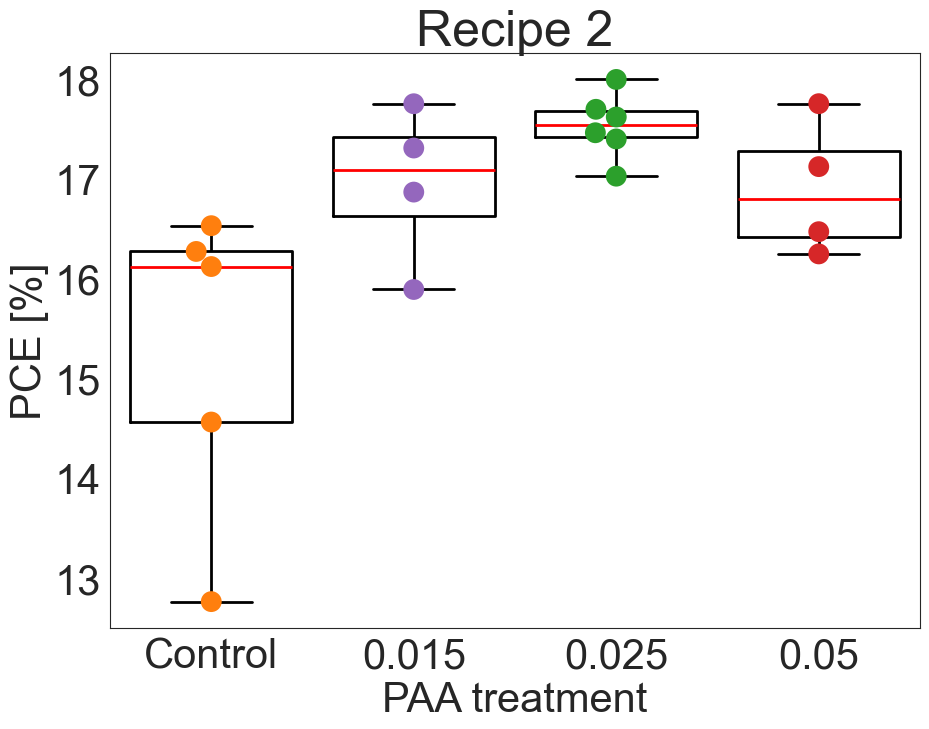

In [76]:
data = device_data[device_data["Recepie"].isin([2])]
# data[["JV. Reverse scan. PCE [%] ", "Recepie", "PAA_treatment"]]

# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

col = sns.color_palette("tab10")

sns.boxplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "0.015", "0.025", "0.05"],
            ax=ax
              )

sns.swarmplot(data=data, y="JV. Reverse scan. PCE [%] ", x="PAA",
              order=["Control", "0.015", "0.025", "0.05"],
              palette=[col[1], col[4], col[2], col[3] ],
              size=15,
              ax=ax
              )


ax.set_xlabel("PAA treatment")
ax.set_ylabel("PCE [%]")
ax.set_title("Recipe 2")

# fileName = 'Boxplots recipe 2 PCE v1'
# save_figure(path_figure_folder, fileName, fig)

C:\Users\jespe\AppData\Local\Temp\ipykernel_32712\619820557.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",


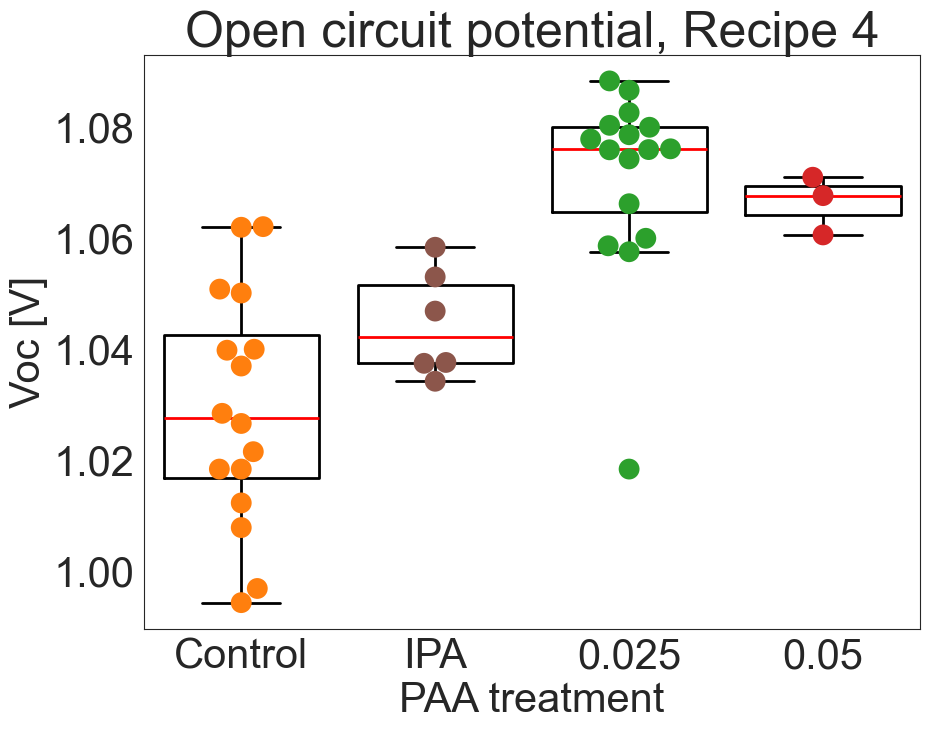

In [85]:
data = device_data[device_data["Recepie"].isin([4])]
# data[["JV. Reverse scan. PCE [%] ", "Recepie", "PAA_treatment"]]

# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

col = sns.color_palette("tab10")

sns.boxplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA", 
            medianprops={"color": "r", "linewidth": 2},
            linewidth=2,
            color="black",
            fill=False,
            order=["Control", "IPA", "0.025", "0.05"],
            ax=ax
              )

sns.swarmplot(data=data, y="JV. Reverse scan. Voc [V]", x="PAA",
              order=["Control", "IPA", "0.025", "0.05"],
              palette=[col[1], col[5], col[2], col[3] ],
              size=15,
              ax=ax
              )

ax.set_xlabel("PAA treatment")
ax.set_ylabel("Voc [V]")
ax.set_title("Open circuit potential, Recipe 4")

# fileName = 'Boxplots recipe 4 Voc v1'
# save_figure(path_figure_folder, fileName, fig)

### NMR data

In [74]:
# File paths
files = ["1.csv","2.csv","3.csv" ]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "NMR")
path_data = [os.path.join(path_data_folder, file) for file in files]

# Read in data 
NMR = [pd.read_csv(path, header=None, names=["Chemical shift (ppm)", "Intensity (a.u.)"]) for path in path_data]

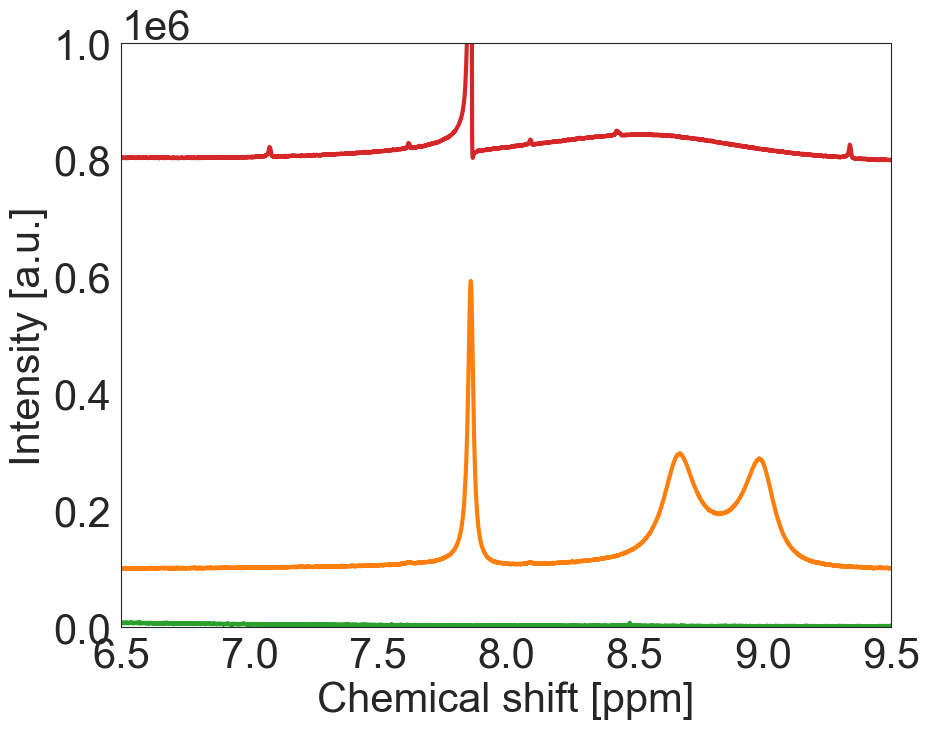

In [76]:
# Plot magnified combined image of inportant part
offsets = [0, 100000, 800000]
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot


l_1 = sns.lineplot(data=NMR[1], x="Chemical shift (ppm)", y=NMR[1]["Intensity (a.u.)"] , 
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PAA",
                ax=ax
                )
l_1 = sns.lineplot(data=NMR[0], x="Chemical shift (ppm)", y=NMR[0]["Intensity (a.u.)"]+ offsets[1], 
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="FAI",
                ax=ax
                )
l_1 = sns.lineplot(data=NMR[2], x="Chemical shift (ppm)", y=NMR[2]["Intensity (a.u.)"] + offsets[2], 
                color=sns.color_palette("tab10")[3],
                lw=3,
                label="PAA+FAI",
                ax=ax
                )


ax.set_xlim([6.5,9.5])
ax.set_ylim([0, 1000000])

ax.set_xlabel("Chemical shift [ppm]")
ax.set_ylabel("Intensity [a.u.]")

ax.legend(fontsize=24)

ax.get_legend().set_visible(False)
# fileName = 'NMR v2'
# save_figure(path_figure_folder, fileName, fig)

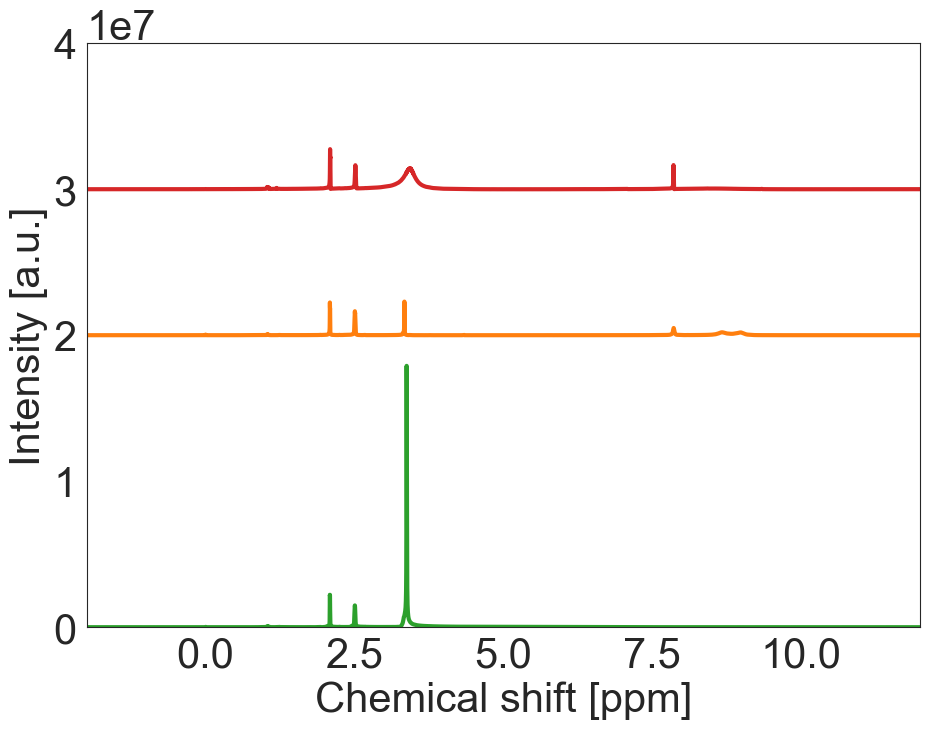

In [77]:
#Plot combined image 
offsets = [0, 20000000, 30000000]
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot


l_1 = sns.lineplot(data=NMR[1], x="Chemical shift (ppm)", y=NMR[1]["Intensity (a.u.)"] , 
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PAA",
                ax=ax
                )
l_1 = sns.lineplot(data=NMR[0], x="Chemical shift (ppm)", y=NMR[0]["Intensity (a.u.)"]+ offsets[1], 
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="FAI",
                ax=ax
                )
l_1 = sns.lineplot(data=NMR[2], x="Chemical shift (ppm)", y=NMR[2]["Intensity (a.u.)"] + offsets[2], 
                color=sns.color_palette("tab10")[3],
                lw=3,
                label="PAA+FAI",
                ax=ax
                )


ax.set_xlim([-2,12])
ax.set_ylim([0, 40000000])

ax.set_xlabel("Chemical shift [ppm]")
ax.set_ylabel("Intensity [a.u.]")

ax.legend(fontsize=24)

ax.get_legend().set_visible(False)
# fileName = 'NMR v1'
# save_figure(path_figure_folder, fileName, fig)

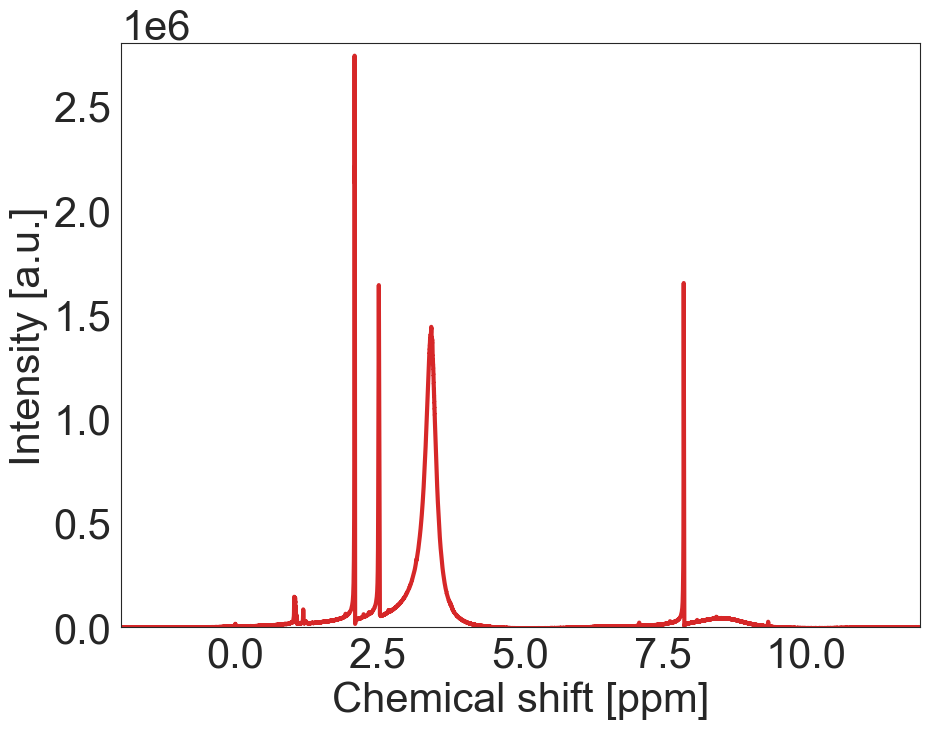

In [78]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot

l_1 = sns.lineplot(data=NMR[2], x="Chemical shift (ppm)", y=NMR[2]["Intensity (a.u.)"] , 
                color=sns.color_palette("tab10")[3],
                lw=3,
                label="PAA+FAI",
                ax=ax
                )

ax.set_xlim([-2,12])
ax.set_ylim([0, 2800000])

ax.set_xlabel("Chemical shift [ppm]")
ax.set_ylabel("Intensity [a.u.]")

ax.legend(fontsize=24)

ax.get_legend().set_visible(False)
# fileName = 'NMR PAA+FAI'
# save_figure(path_figure_folder, fileName, fig)

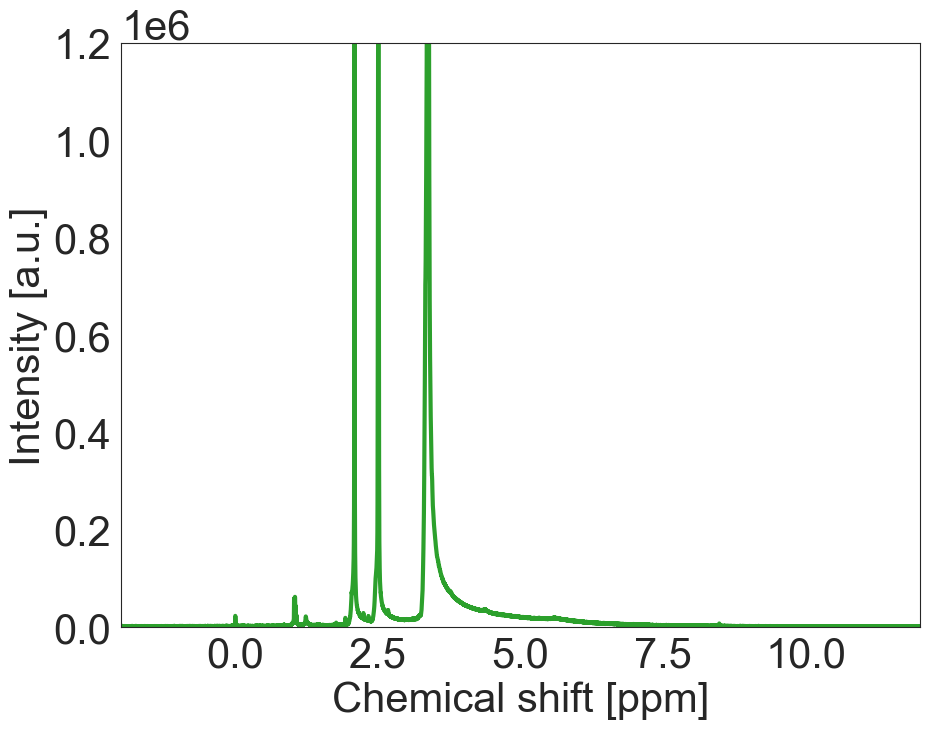

In [79]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot

l_1 = sns.lineplot(data=NMR[1], x="Chemical shift (ppm)", y=NMR[1]["Intensity (a.u.)"] , 
                color=sns.color_palette("tab10")[2],
                lw=3,
                label="PAA",
                ax=ax
                )

ax.set_xlim([-2,12])
ax.set_ylim([0, 1200000])

ax.set_xlabel("Chemical shift [ppm]")
ax.set_ylabel("Intensity [a.u.]")

ax.legend(fontsize=24)

ax.get_legend().set_visible(False)
# fileName = 'NMR PAA'
# save_figure(path_figure_folder, fileName, fig)

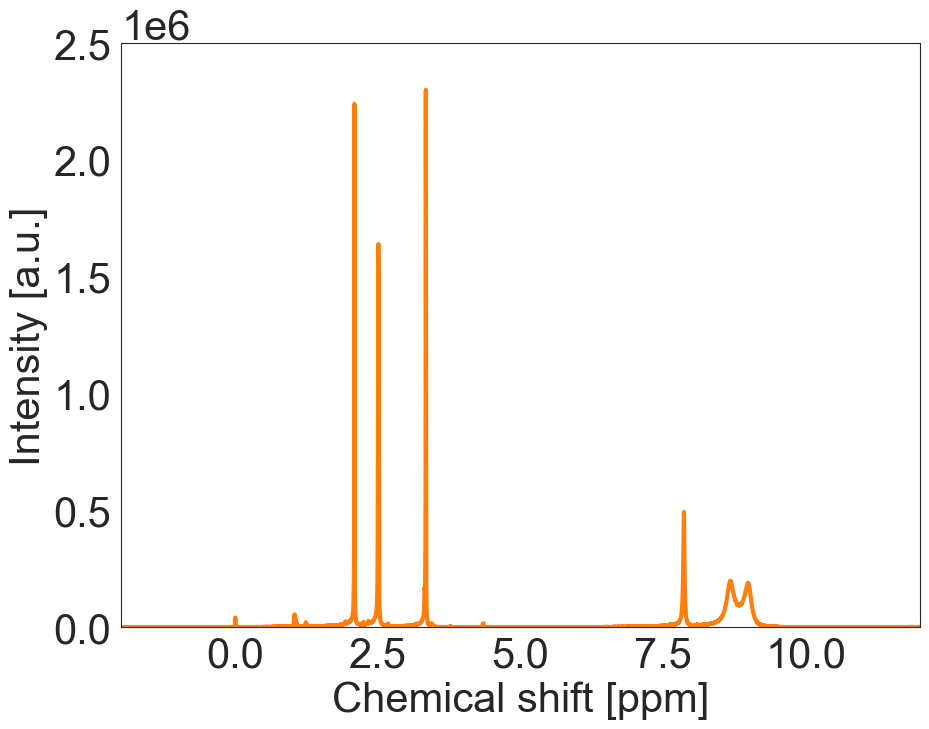

In [80]:
# Apply a default plot theme
sns.set_style("white")
# Changing the font size for all elements in the plot
plt.rcParams.update({'font.size': 30})
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 8), tight_layout=True)

# Generate a line plot

l_1 = sns.lineplot(data=NMR[0], x="Chemical shift (ppm)", y=NMR[0]["Intensity (a.u.)"], 
                color=sns.color_palette("tab10")[1],
                lw=3,
                label="FAI",
                ax=ax
                )



ax.set_xlim([-2,12])
ax.set_ylim([0, 2500000])

ax.set_xlabel("Chemical shift [ppm]")
ax.set_ylabel("Intensity [a.u.]")

ax.legend(fontsize=24)

ax.get_legend().set_visible(False)
# fileName = 'NMR FAI'
# save_figure(path_figure_folder, fileName, fig)

### SEM

In [81]:
# File paths
files = ["control-50000.xlsx","IPA-50000.xlsx", "0.025%PAA-50001.xlsx", "0.05% PAA-50000.xlsx", "0.5%PAA-50000.xlsx"]
path_data_folder = os.path.join(os.path.abspath(os.getcwd()), "Data", "SEM")
path_data = [os.path.join(path_data_folder, file) for file in files]

# Read in data for forward and reversed scan in separate dataframes
Particle_diameter = [pd.read_excel(path) for path in path_data]

In [82]:
df1=Particle_diameter[0]
df2=Particle_diameter[1]
df3=Particle_diameter[2]
df4=Particle_diameter[3]
df5=Particle_diameter[4]

Text(0.5, 1.0, 'Control')

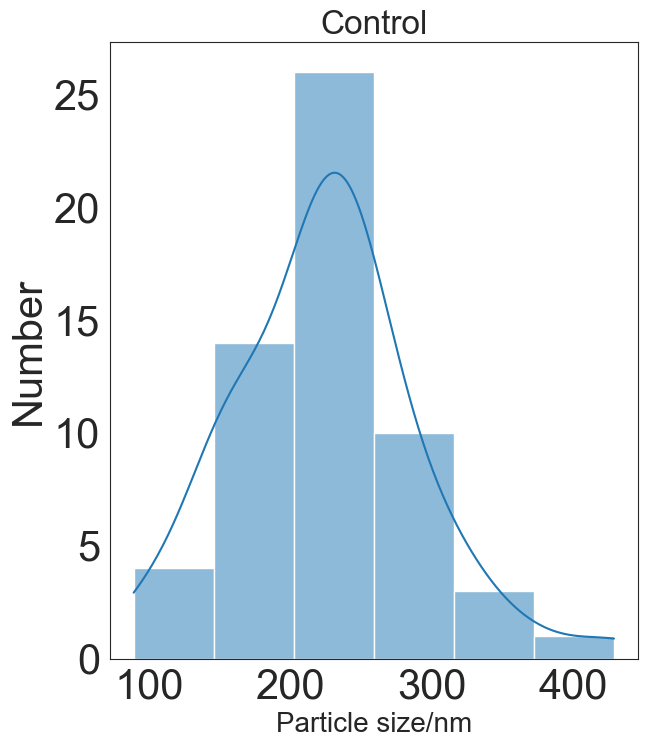

In [83]:
# control
fig, ax = plt.subplots(figsize=(7, 8), tight_layout=True)
sns.set_theme(style="ticks", palette="muted")
sns.set(context='notebook', style='ticks', font_scale=2)
g=sns.histplot(data=df1,x="Particle size/nm",bins=6, kde=True)
g.set_xlabel( "Particle size/nm",fontsize=20)
g.set_ylabel( "Number")
g.set_title("Control")
# fileName = 'control_50000_particle_diameter v1'
# save_figure(path_figure_folder, fileName, fig)

In [ ]:
#IPA
fig, ax = plt.subplots(figsize=(7, 8), tight_layout=True)
sns.set_theme(style="ticks", palette="muted")
sns.set(context='notebook', style='ticks', font_scale=2)
g=sns.histplot(data=df2,x="Particle size/nm",bins=6, kde=True)
g.set_xlabel( "Particle size/nm",fontsize=20)
g.set_ylabel( "Number")
g.set_title("IPA")
# fileName = 'IPA_50000_particle_diameter v1'
# save_figure(path_figure_folder, fileName, fig)

In [ ]:
#0.025%PAA
fig, ax = plt.subplots(figsize=(7, 8), tight_layout=True)
sns.set_theme(style="ticks", palette="muted")
sns.set(context='notebook', style='ticks', font_scale=2)
g=sns.histplot(data=df3,x="Particle size/nm",bins=6, kde=True)
g.set_xlabel( "Particle size/nm",fontsize=20)
g.set_ylabel( "Number")
g.set_title("0.025%PAA")
# fileName = '0.025%PAA_50000_particle_diameter v1'
# save_figure(path_figure_folder, fileName, fig)

In [ ]:
#0.05%PAA
fig, ax = plt.subplots(figsize=(7, 8), tight_layout=True)
sns.set_theme(style="ticks", palette="muted")
sns.set(context='notebook', style='ticks', font_scale=2)
g=sns.histplot(data=df2,x="Particle size/nm",bins=6, kde=True)
g.set_xlabel( "Particle size/nm",fontsize=20)
g.set_ylabel( "Number")
g.set_title("0.05%PAA")
# fileName = '0.05%PAA_50000_particle_diameter v1'
# save_figure(path_figure_folder, fileName, fig)

In [ ]:
#0.5%PAA
fig, ax = plt.subplots(figsize=(7, 8), tight_layout=True)
sns.set_theme(style="ticks", palette="muted")
sns.set(context='notebook', style='ticks', font_scale=2)
g=sns.histplot(data=df2,x="Particle size/nm",bins=6, kde=True)
g.set_xlabel( "Particle size/nm",fontsize=20)
g.set_ylabel( "Number")
g.set_title("0.5%PAA")
# fileName = '0.5%PAA_50000_particle_diameter v1'
# save_figure(path_figure_folder, fileName, fig)